In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from Distant_SigMA.SigMA.SigMA import SigMA
from Distant_SigMA.SigMA import DensityEstimator

# Generate mock data

In [4]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [5]:
# Create 6D Gaussian data
np.random.seed(42) 
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([-12, 10, -10, -10, 15, -18])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-11, -10, 13, -7, -7, 18])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([10, 10, 15, 10, -15, -20])
c_xx_5 = c_yy_5 = 32
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

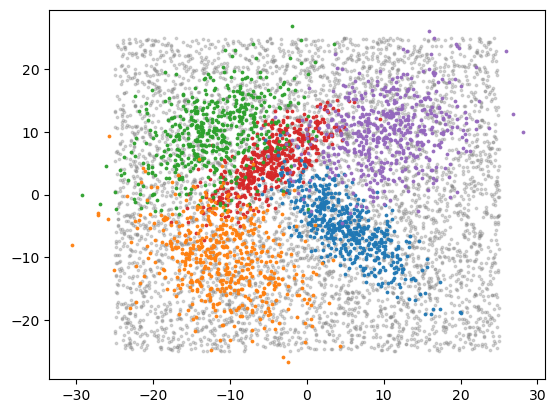

In [6]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

In [7]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     -6.272994  22.535715  11.599697   4.932924 -17.199068 -17.200274   
1    -22.095819  18.308807   5.055751  10.403629 -23.970775  23.495493   
2     16.622132 -14.383044 -15.908752 -15.829775  -9.787888   1.237822   
3     -3.402749 -10.438543   5.592645 -18.025307 -10.392768  -6.681908   
4     -2.196501  14.258798 -15.016311   0.711722   4.620728 -22.677479   
...         ...        ...        ...        ...        ...        ...   
7495   0.318430   0.648008  14.767137  10.876024 -15.135884 -18.447722   
7496   5.940312  12.321013  16.776978   8.326091 -16.844013 -20.403112   
7497  18.546338  17.914509   9.237268  10.856226 -14.866233 -20.159990   
7498   4.620124  10.868567  16.013856   9.148356 -15.105983 -20.323542   
7499  14.467780   3.492152  17.611243  10.321478 -14.846155 -20.956594   

              ra        dec       dist        pmra       pmdec  \
0     281.680238  74.477071  26.110571   59.7

# Apply TreeSigMA

In [9]:
from TreeSigMA import TreeSigMAWithHierarchy  

knn_list=[15, 20, 25, 30]
cluster_features=['x', 'y', 'z']
sigma_kwargs = dict(
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

# Initialize TreeSigMA
tree_sigma = TreeSigMAWithHierarchy(
    data=df,
    cluster_features=cluster_features,
    **sigma_kwargs
)

# Run the SigMA clustering and build the hierarchy
print("Running TreeSigMA clustering...")
alpha_values = tree_sigma.run()
print("Clustering completed. Alpha values:", alpha_values)

# Build hierarchy 
print("\nBuilding hierarchy...")
tree_sigma.build_hierarchy()
print("Hierarchy built.")

# Traverse the tree
print("\nTop-down traversal:")
for node in tree_sigma.hierarchy.traverse_top_down():
    print(f"Node ID: {node.node_id}, Parent: {node.parent.node_id if node.parent else None}, "
          f"Children: {[child.node_id for child in node.children]}") # evt. , Data: {node.data}

print("\nBottom-up traversal:")
for node in tree_sigma.hierarchy.traverse_bottom_up():
    print(f"Node ID: {node.node_id}, Parent: {node.parent.node_id if node.parent else None}, "
          f"Children: {[child.node_id for child in node.children]}") # evt. , Data: {node.data}

# Access a specific node and analyze
print("\nInspecting a specific node...")
node_id = list(tree_sigma.hierarchy.nodes.keys())[0]  # Pick the desired node ID
node = tree_sigma.hierarchy.nodes[node_id]
print(f"Node ID: {node.node_id}")
print(f"Parent ID: {node.parent.node_id if node.parent else 'Root'}")
print(f"Children IDs: {[child.node_id for child in node.children]}")
#print(f"Data: {node.data}")

# Example: Analyzing the leaves
print("\nAnalyzing leaves:")
leaves = [node for node in tree_sigma.hierarchy.traverse_top_down() if node.is_leaf()]
for leaf in leaves:
    print(f"Leaf ID: {leaf.node_id}")

Performing gradient ascend using a 20-NN density estimation.
Running TreeSigMA clustering...
Clustering completed. Alpha values: [2.7200464103316335e-14, 8.358314040890491e-13, 7.849489391809072e-10, 0.008350465821492625, 0.017127265996220442, 0.024698097782602402, 0.03752241188654126, 0.04748529519762862, 0.07662375372192787, 0.10769685157837172, 0.12792206847670234, 0.14806420550879157, 0.1663054183057111, 0.1865651302903229, 0.19707690418024099]

Building hierarchy...
uniq [(2.7200464103316335e-14, '5485_2.7200464103316335e-14')]
Adding node 5485_2.7200464103316335e-14 (original label 5485) with parent virtual_root, alpha 2.7200464103316335e-14
uniq [(2.7200464103316335e-14, '5701_2.7200464103316335e-14')]
Adding node 5701_2.7200464103316335e-14 (original label 5701) with parent virtual_root, alpha 2.7200464103316335e-14
uniq [(2.7200464103316335e-14, '5701_2.7200464103316335e-14'), (8.358314040890491e-13, '5701_8.358314040890491e-13')]
Adding node 5701_8.358314040890491e-13 (origin

# Plot the Hierarchy

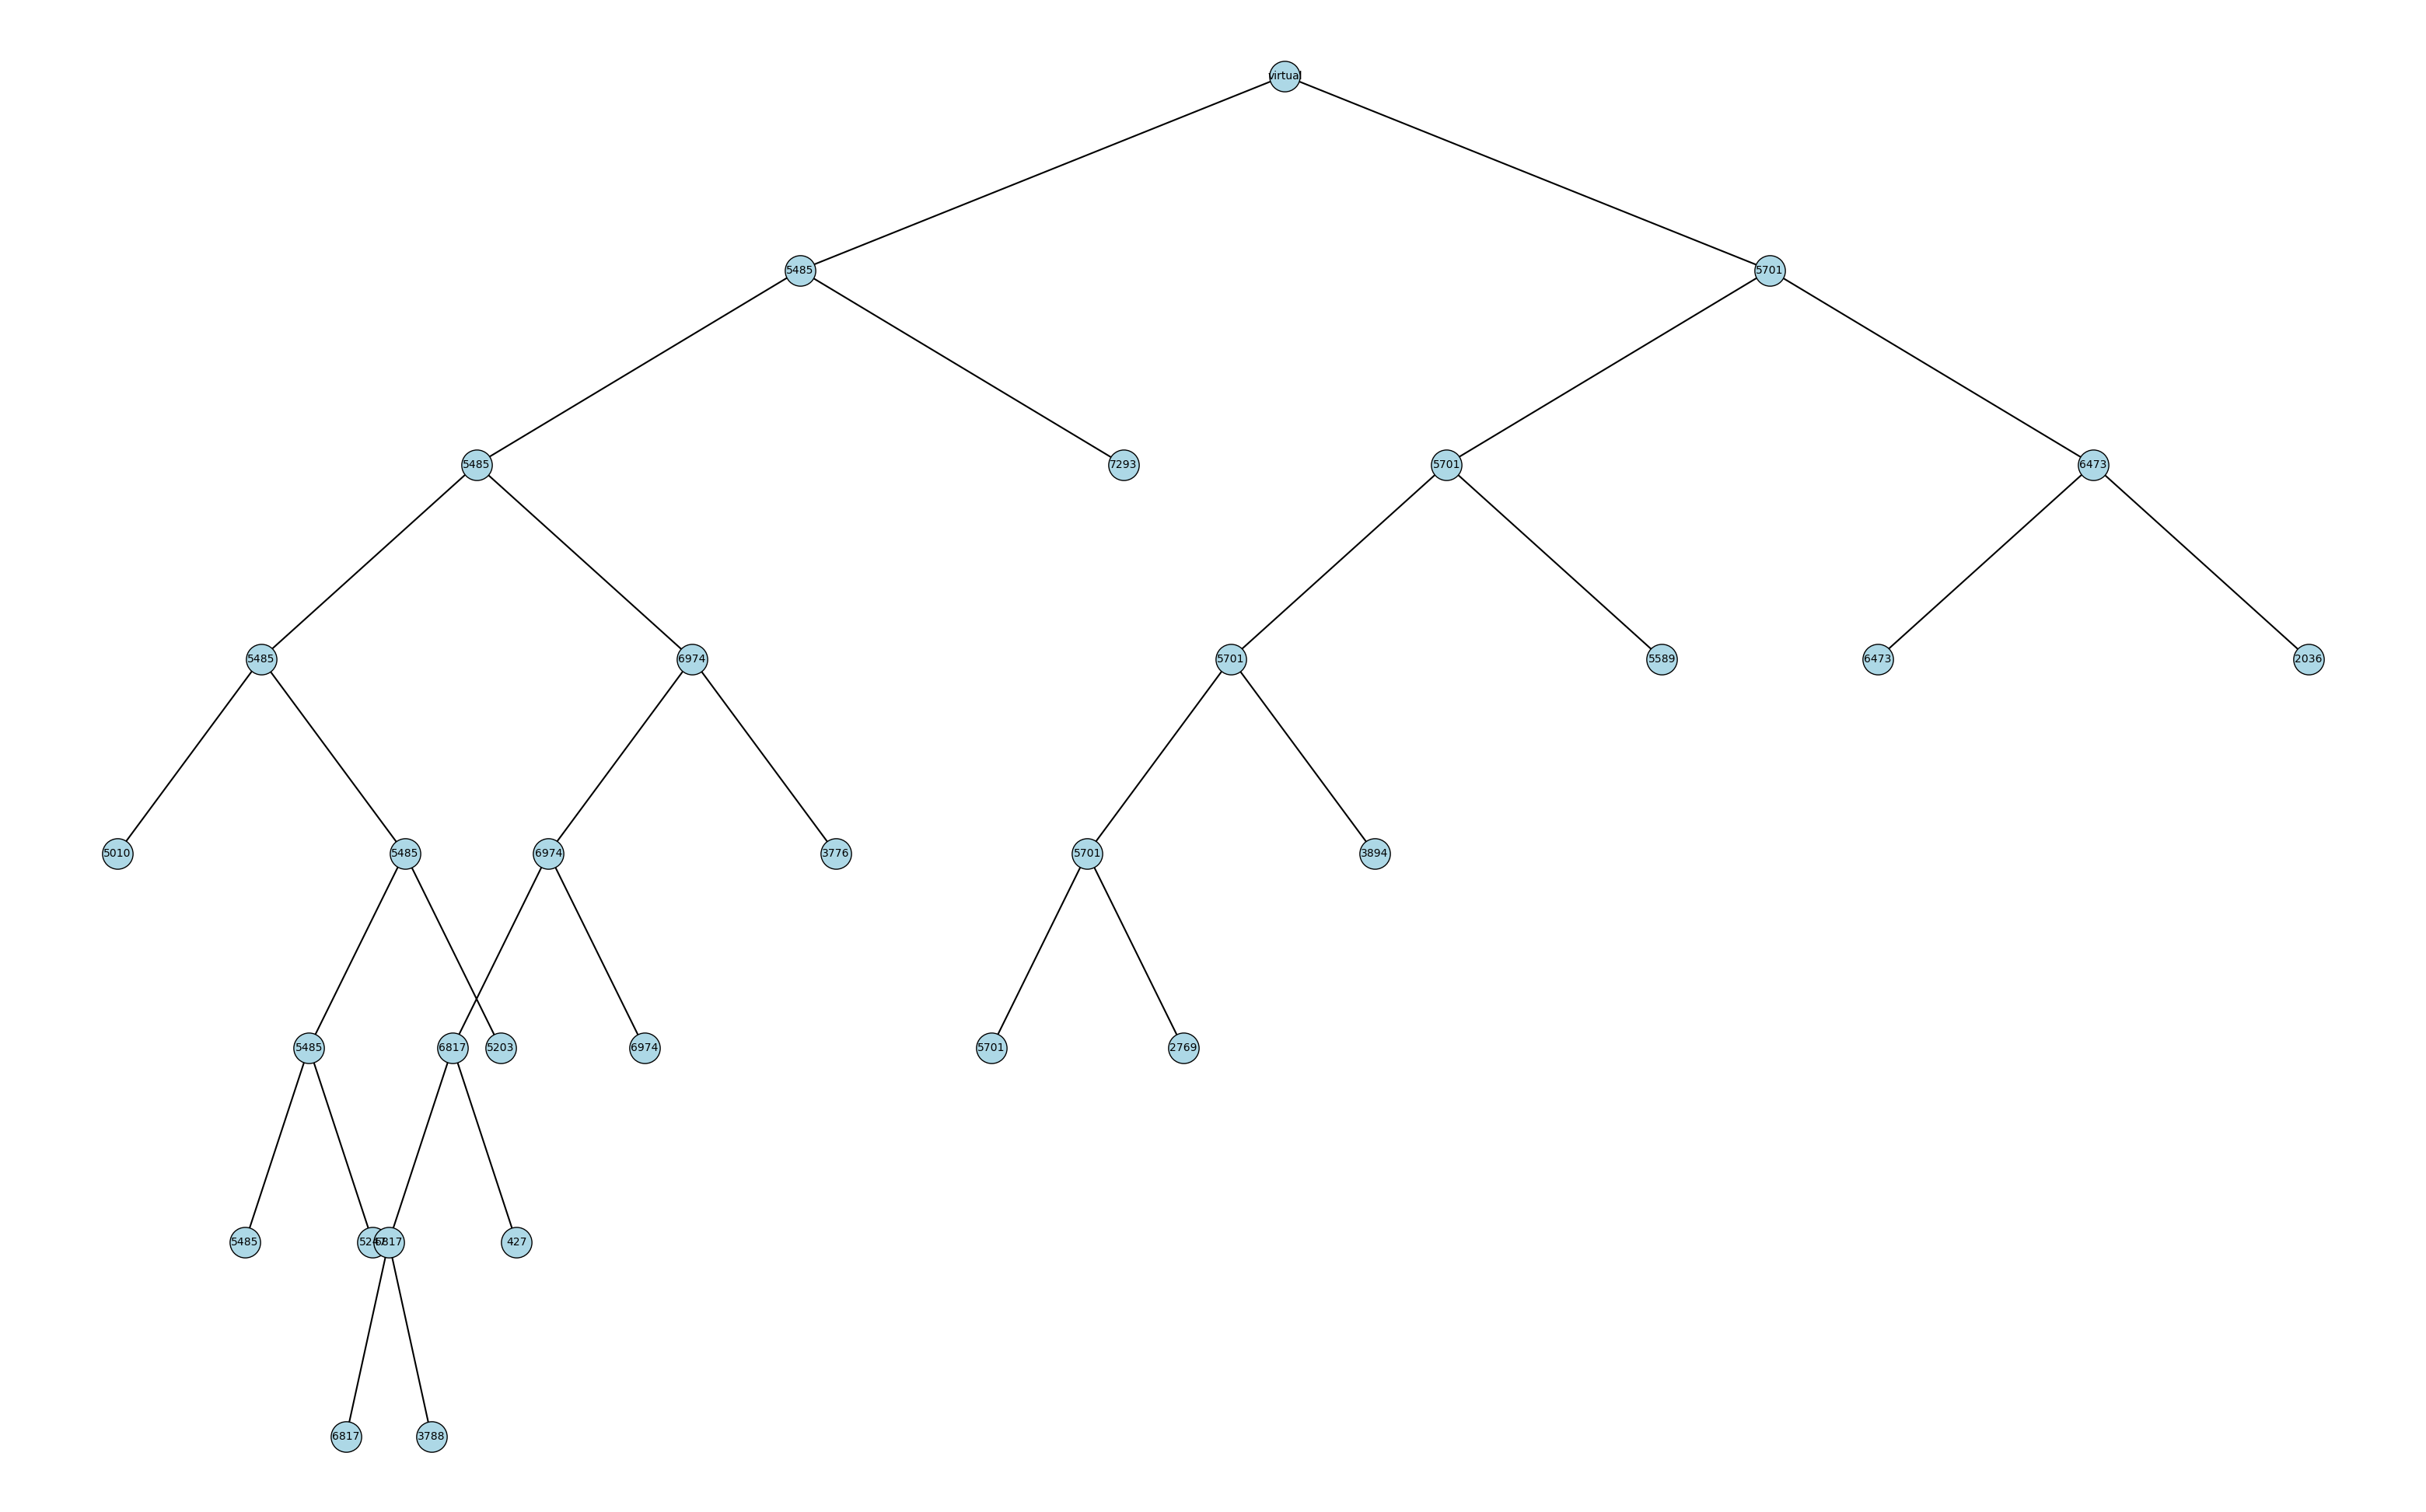

In [11]:
def plot_tree(node, x=0, y=0, level=0, x_spacing=1.5, y_spacing=1.5, node_positions=None, parent_positions=None, parent=None):
    """
    Recursively plot tree structure
    
    Args:
        node (TreeNode): The current node to plot.
        x (float): X-coordinate of the current node.
        y (float): Y-coordinate of the current node.
        level (int): Current level in the tree.
        x_spacing (float): Horizontal spacing between nodes.
        y_spacing (float): Vertical spacing between levels.
        node_positions (dict): Dictionary to store node positions for plotting.
        parent_positions (dict): Dictionary to store parent positions for edges.
        parent (tuple): Position of the parent node.
    """
    if node_positions is None:
        node_positions = {}
    if parent_positions is None:
        parent_positions = []

    # Store the current node's position
    node_positions[node.node_id] = (x, y)
    if parent is not None:
        parent_positions.append((parent, (x, y)))

    # Compute positions for children
    n_children = len(node.children)
    for i, child in enumerate(node.children):
        child_x = x - x_spacing * (n_children - 1) / 2 + i * x_spacing
        child_y = y - y_spacing
        plot_tree(child, x=child_x, y=child_y, level=level + 1,
                  x_spacing=x_spacing / 1.5, y_spacing=y_spacing,
                  node_positions=node_positions, parent_positions=parent_positions,
                  parent=(x, y))
    
    # Plot when at the root level
    if level == 0:
        fig, ax = plt.subplots(figsize=(40, 25))
        for (start, end) in parent_positions:
            ax.plot([start[0], end[0]], [start[1], end[1]], 'k-', zorder=1)
        for node_id, (nx, ny) in node_positions.items():
            current_node = tree_sigma.hierarchy.nodes[node_id]
            original_label = current_node.node_id.split('_')[0] # Get the original_label
            ax.scatter(nx, ny, s=800, c='lightblue', edgecolors='black', zorder=2)
            #ax.text(nx, ny, str(node_id), fontsize=10, ha='center', va='center', zorder=3)
            ax.text(nx, ny, f"{original_label}", fontsize=10, ha='center', va='center', zorder=3)
        ax.axis('off')
        plt.show()

plot_tree(tree_sigma.hierarchy.root)

# Get all nodes at certain Alpha level

### using node indices at specific alpha value

In [14]:
#Get all nodes
node_labels = {node.node_id: f"{node.node_id}" for node in tree_sigma.hierarchy.traverse_top_down()}

#Get nodes at certain alpha
nodes_at_alpha = tree_sigma.node_indices[alpha_values[3]]
for label in nodes_at_alpha.keys():
    print(f"Cluster label: {label}")

Cluster label: 5485
Cluster label: 5701
Cluster label: 6974
Cluster label: 6473
Cluster label: 7293


### Get labels for respective star at each alpha level

In [16]:
l = tree_sigma.labels(a_step=3)
print(f"Clusters assigned to stars at alpha level 3: {l}")
print(np.unique(l))


Clusters assigned to stars at alpha level 3: [5485 5485 5701 ... 7293 7293 7293]
[5485 5701 6473 6974 7293]


### Print all Alpha level lists for each node 

In [18]:
for uid in tree_sigma.hierarchy.nodes:
            print(f"Node {uid}: {tree_sigma.hierarchy.nodes[uid].alpha_levels}")  

Node virtual_root: []
Node 5485_2.7200464103316335e-14: [0, 1]
Node 5701_2.7200464103316335e-14: [0]
Node 5701_8.358314040890491e-13: [1, 2, 3, 4, 5]
Node 6473_8.358314040890491e-13: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Node 5485_7.849489391809072e-10: [2]
Node 7293_7.849489391809072e-10: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Node 5485_0.008350465821492625: [3, 4, 5, 6, 7]
Node 6974_0.008350465821492625: [3]
Node 6974_0.017127265996220442: [4]
Node 3776_0.017127265996220442: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Node 6817_0.024698097782602402: [5, 6, 7, 8]
Node 6974_0.024698097782602402: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Node 5701_0.03752241188654126: [6]
Node 5589_0.03752241188654126: [6, 7, 8, 9, 10, 11, 12, 13, 14]
Node 5701_0.04748529519762862: [7, 8, 9, 10, 11, 12, 13]
Node 3894_0.04748529519762862: [7, 8, 9, 10, 11, 12, 13, 14]
Node 5010_0.07662375372192787: [8, 9, 10, 11, 12, 13, 14]
Node 5485_0.07662375372192787: [8, 9]
Node 6817_0.10769685157837172: [9, 10, 11]
No

# Get the star indices for each node 

In [20]:
#for uid in tree_sigma.hierarchy.nodes:
          #  print(f"Node {uid}: {tree_sigma.hierarchy.nodes[uid].data_indices}") 

# Information on survivability of clusters

In [22]:
# Compute survivability after building the hierarchy
tree_sigma.compute_survivability()

# Get survivability for all clusters
print("\nSurvivability of all clusters:")
for cluster_id, survivability in tree_sigma.get_survivability().items():
    print(f"Cluster {cluster_id}: {survivability} alpha levels")

# Query survivability for a specific cluster
specific_cluster = "3776_0.017127265996220442"  # Replace with an actual cluster ID from your hierarchy
print(f"\nSurvivability of {specific_cluster}: {tree_sigma.get_survivability(cluster_id=specific_cluster)}")


Survivability of all clusters:
Cluster 5485_2.7200464103316335e-14: 2 alpha levels
Cluster 5701_2.7200464103316335e-14: 1 alpha levels
Cluster 5701_8.358314040890491e-13: 5 alpha levels
Cluster 6473_8.358314040890491e-13: 12 alpha levels
Cluster 5485_7.849489391809072e-10: 1 alpha levels
Cluster 7293_7.849489391809072e-10: 13 alpha levels
Cluster 5485_0.008350465821492625: 5 alpha levels
Cluster 6974_0.008350465821492625: 1 alpha levels
Cluster 6974_0.017127265996220442: 1 alpha levels
Cluster 3776_0.017127265996220442: 11 alpha levels
Cluster 6817_0.024698097782602402: 4 alpha levels
Cluster 6974_0.024698097782602402: 10 alpha levels
Cluster 5701_0.03752241188654126: 1 alpha levels
Cluster 5589_0.03752241188654126: 9 alpha levels
Cluster 5701_0.04748529519762862: 7 alpha levels
Cluster 3894_0.04748529519762862: 8 alpha levels
Cluster 5010_0.07662375372192787: 7 alpha levels
Cluster 5485_0.07662375372192787: 2 alpha levels
Cluster 6817_0.10769685157837172: 3 alpha levels
Cluster 427_0

# KNN Density

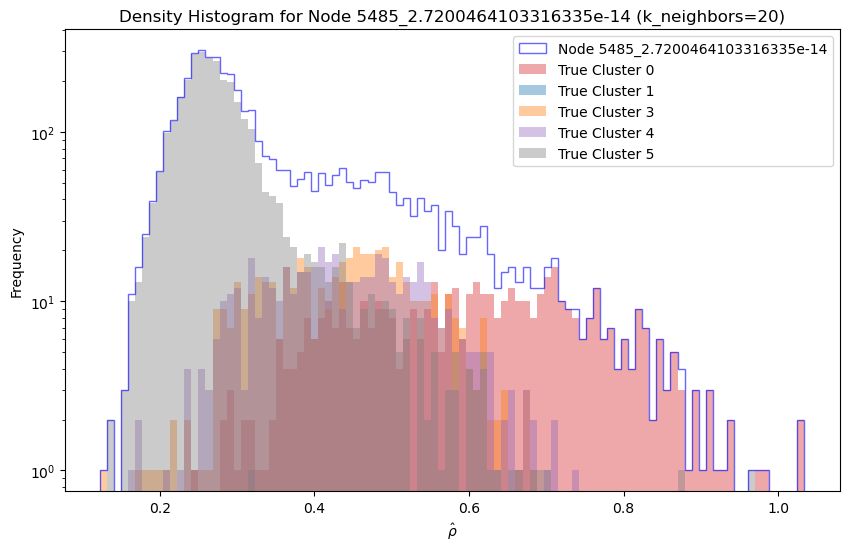

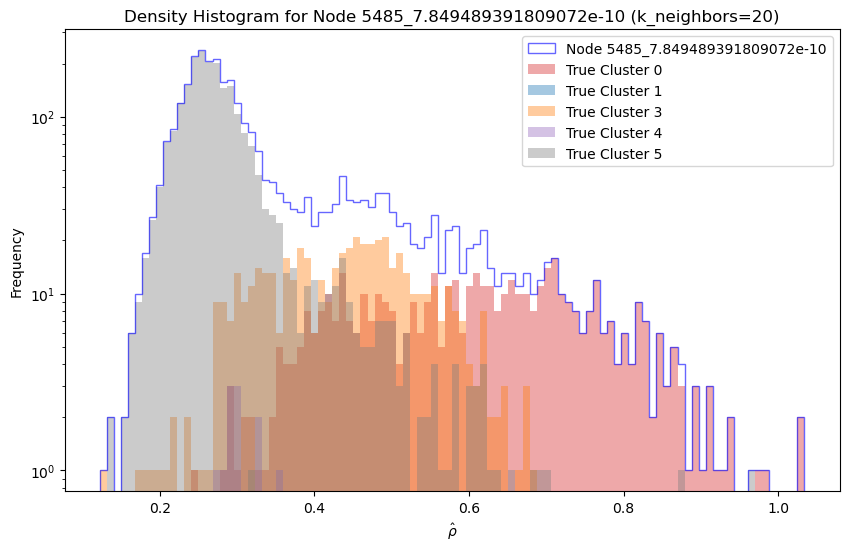

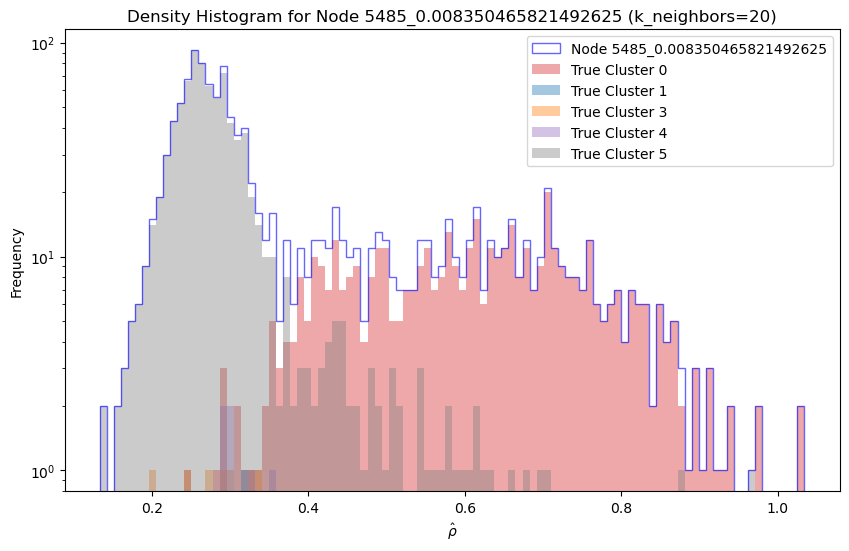

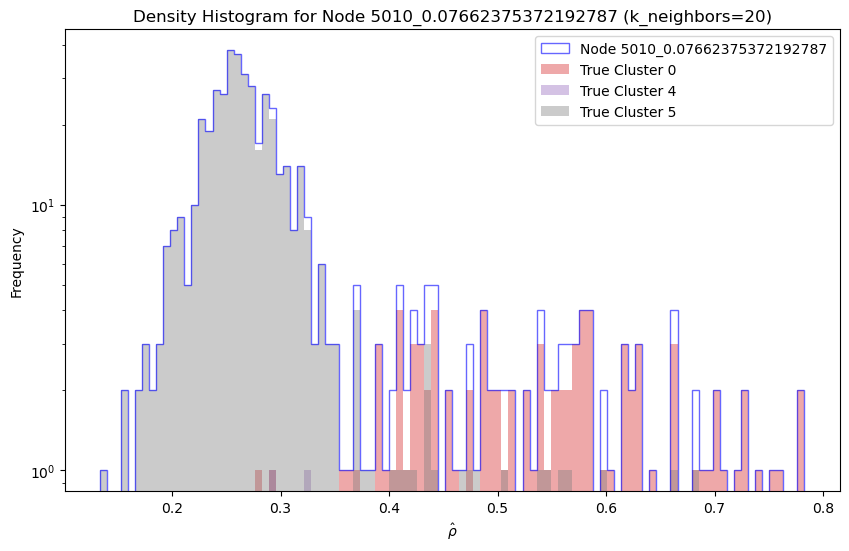

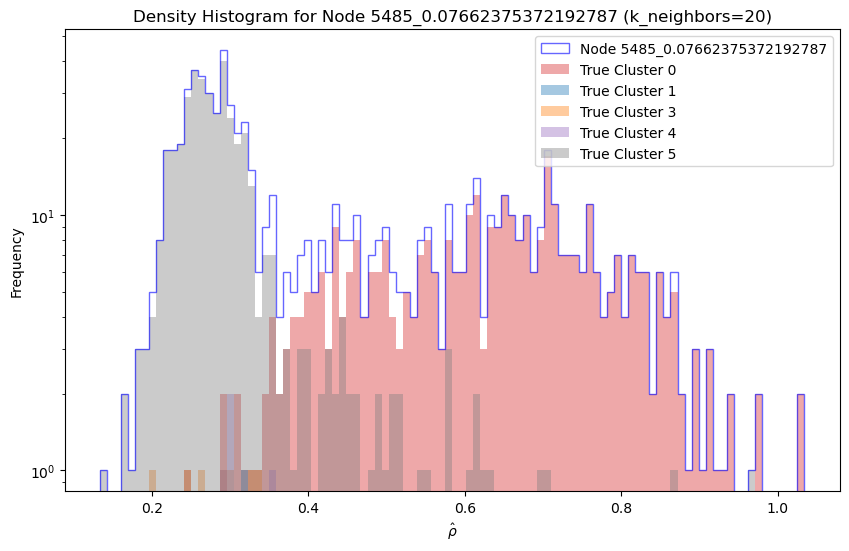

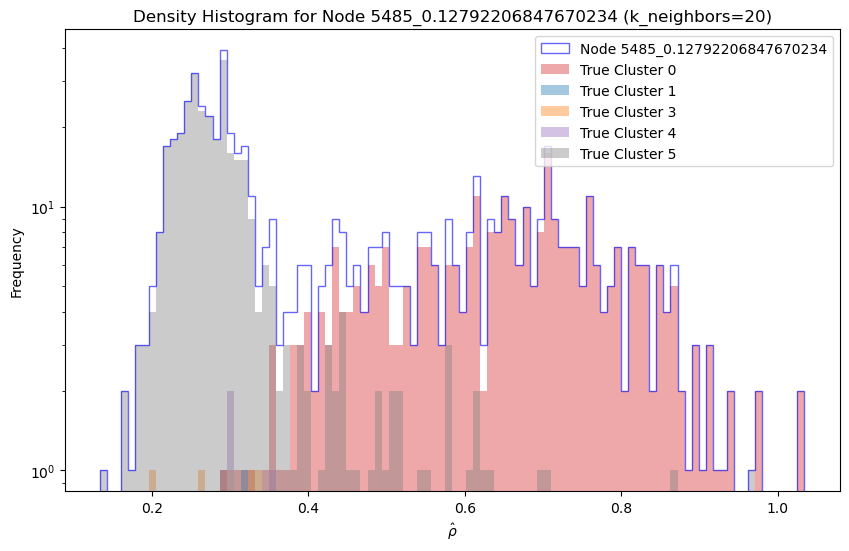

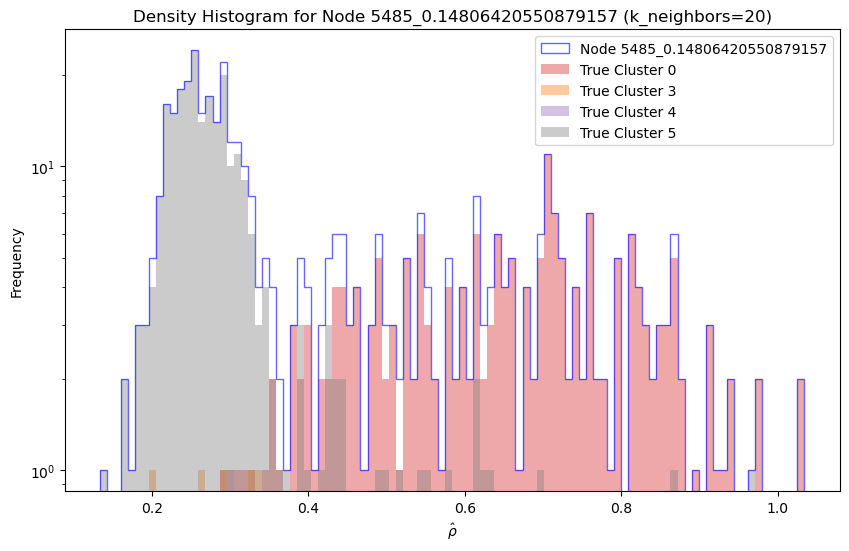

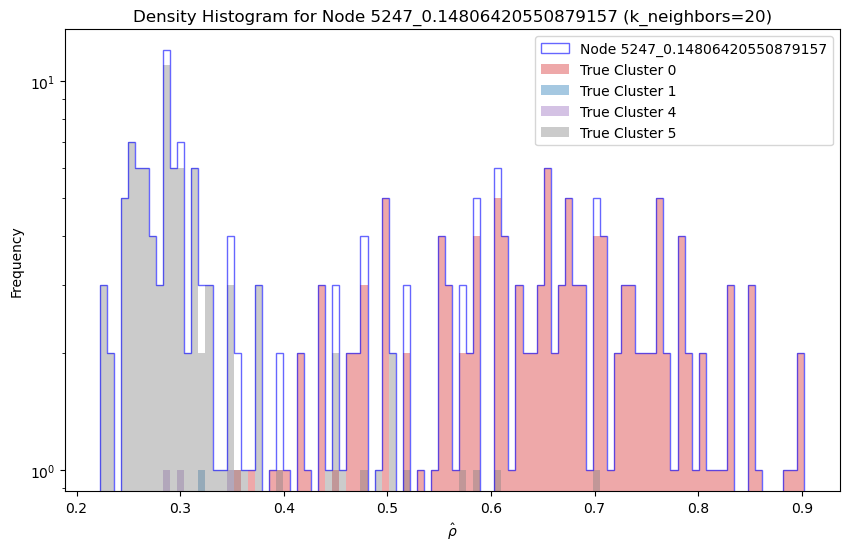

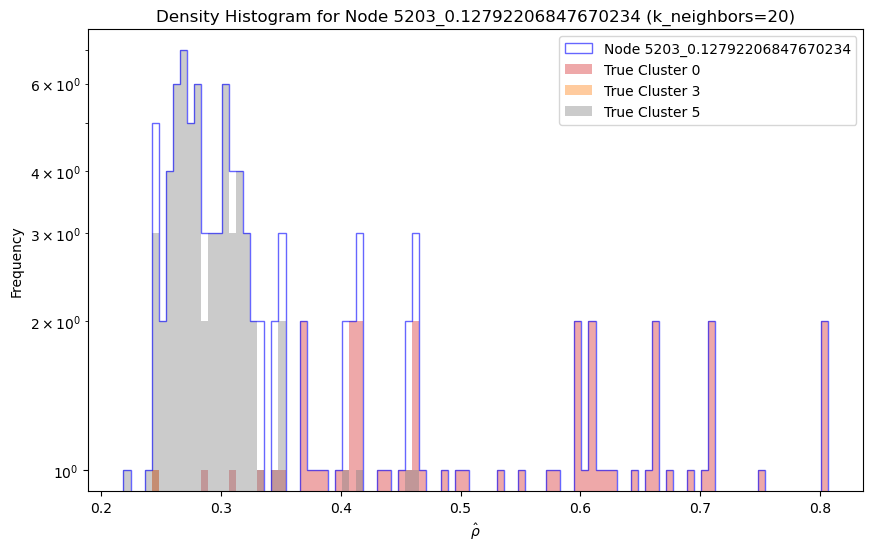

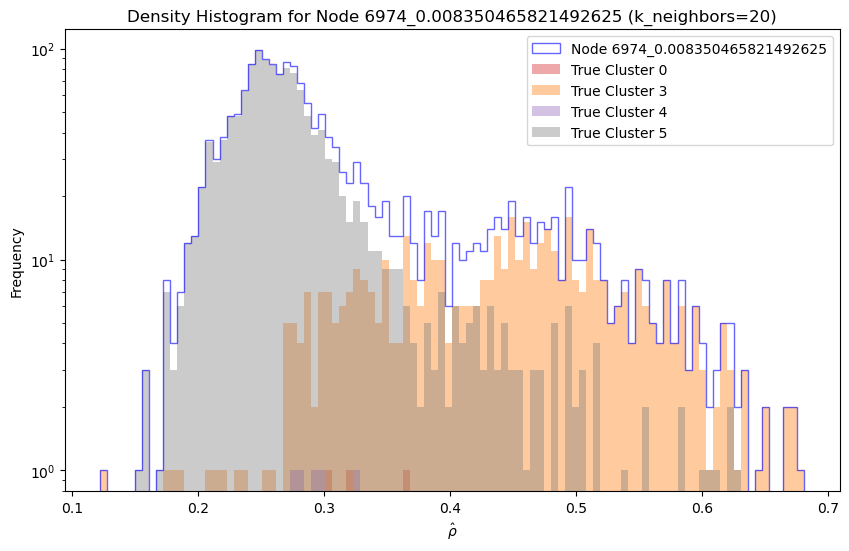

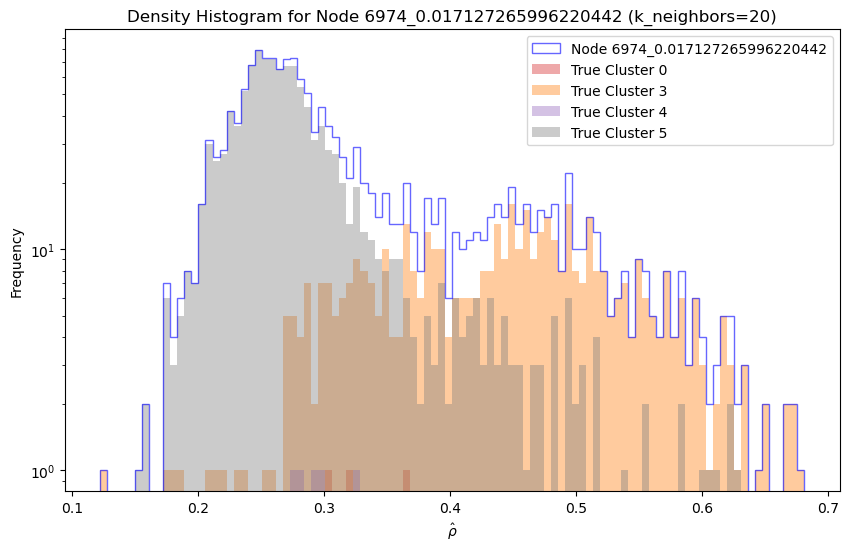

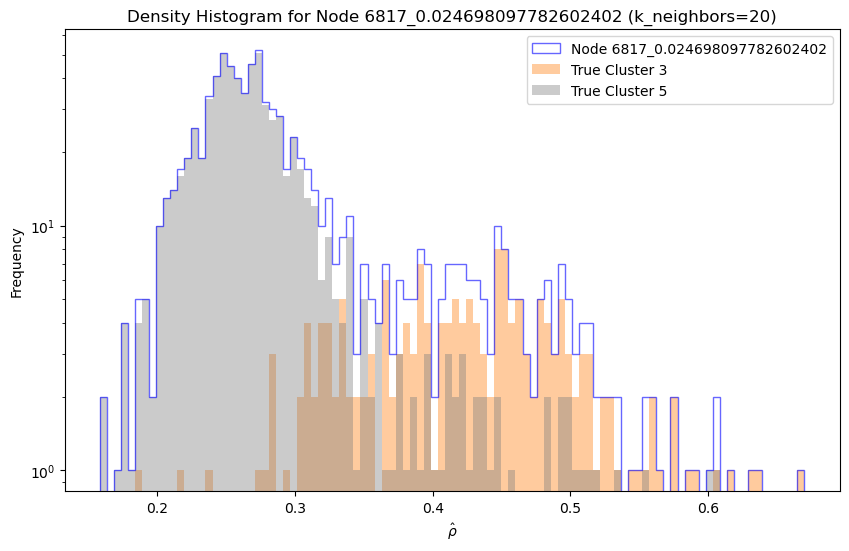

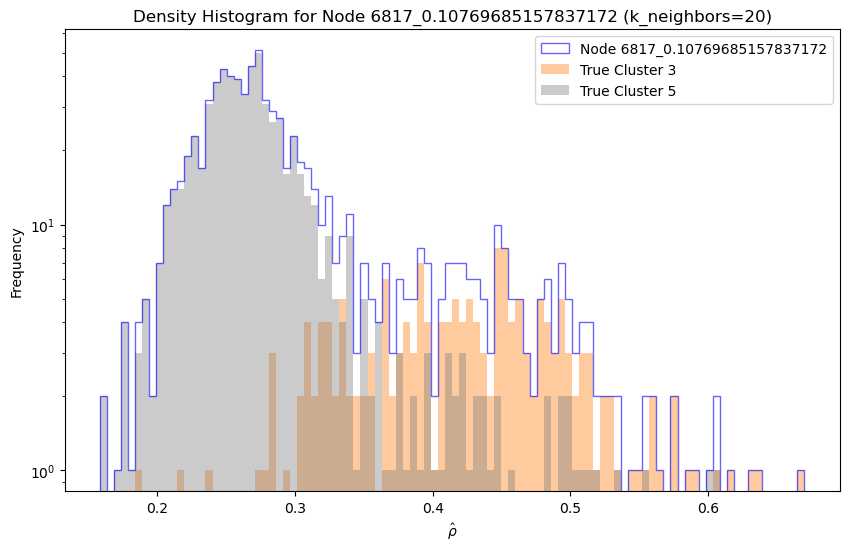

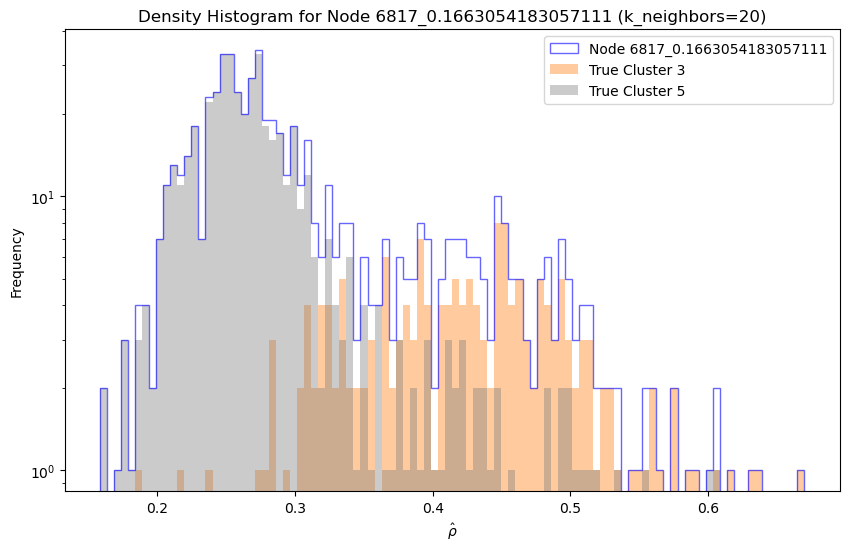

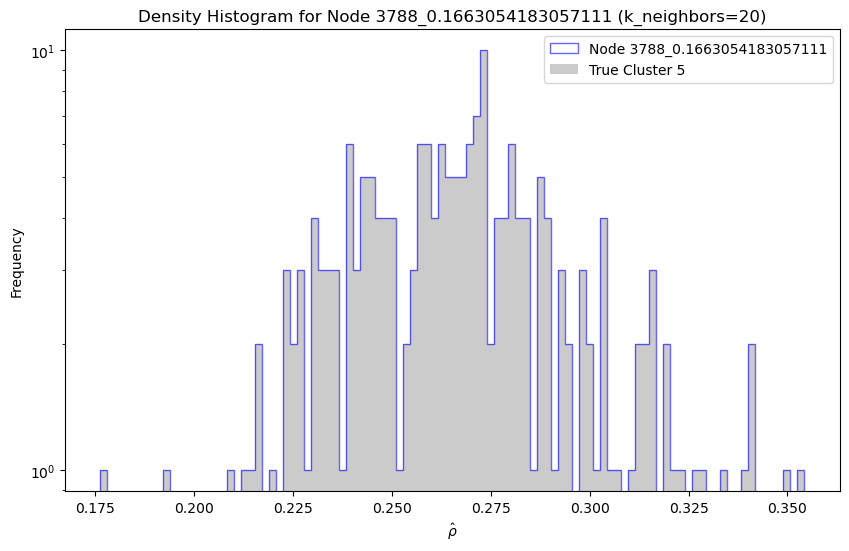

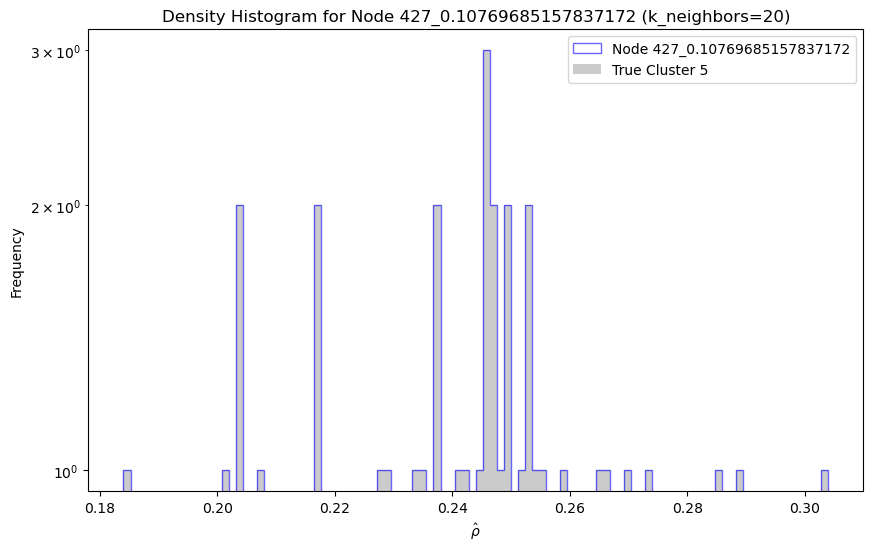

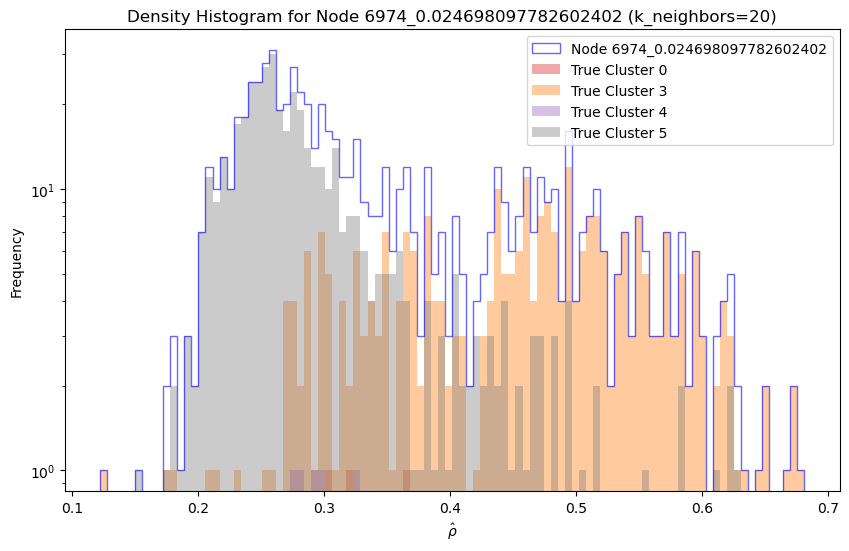

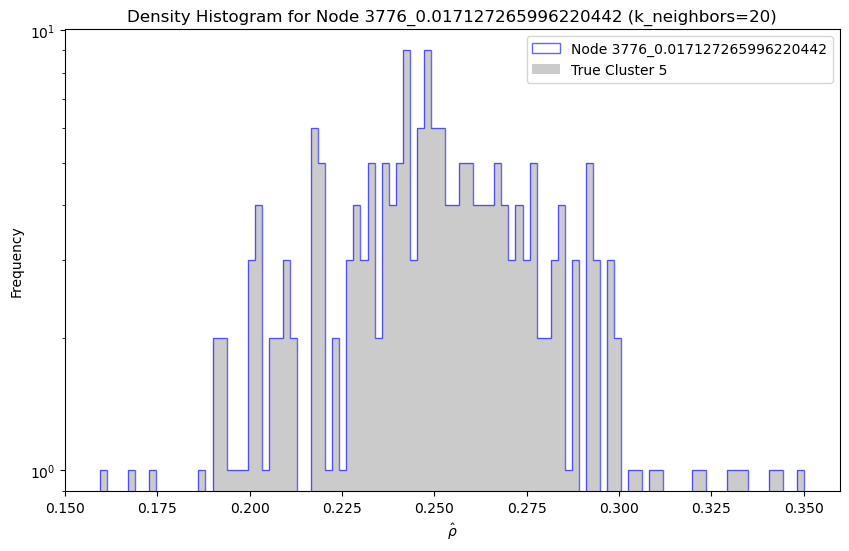

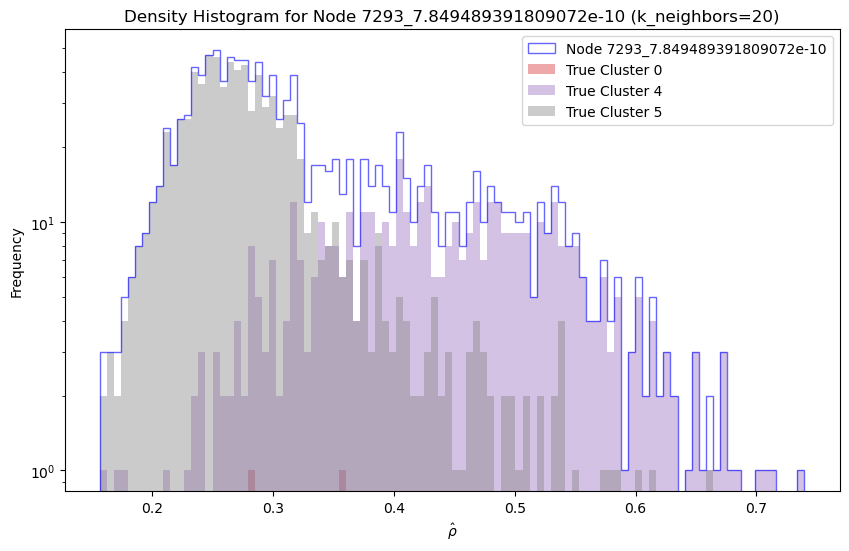

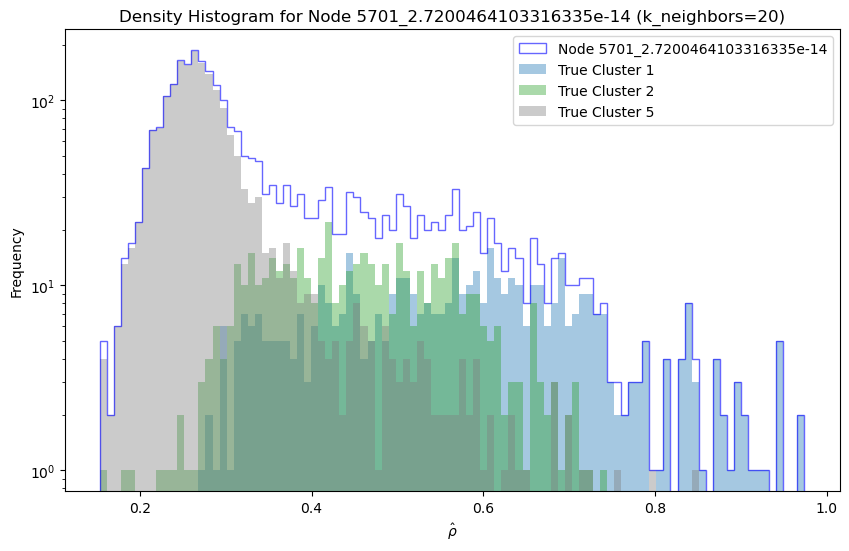

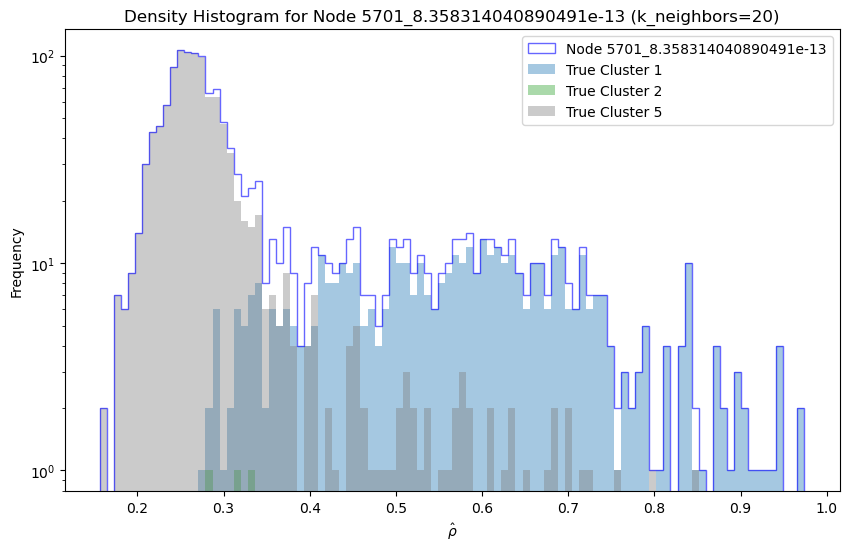

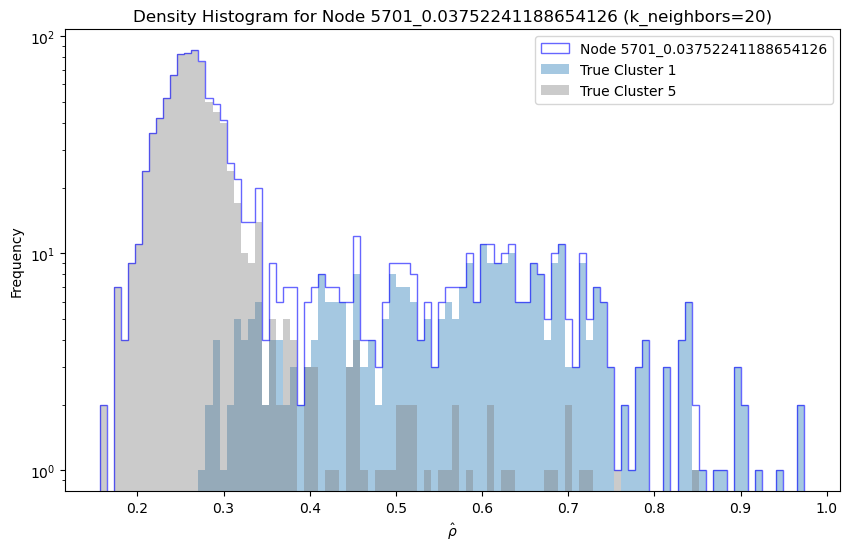

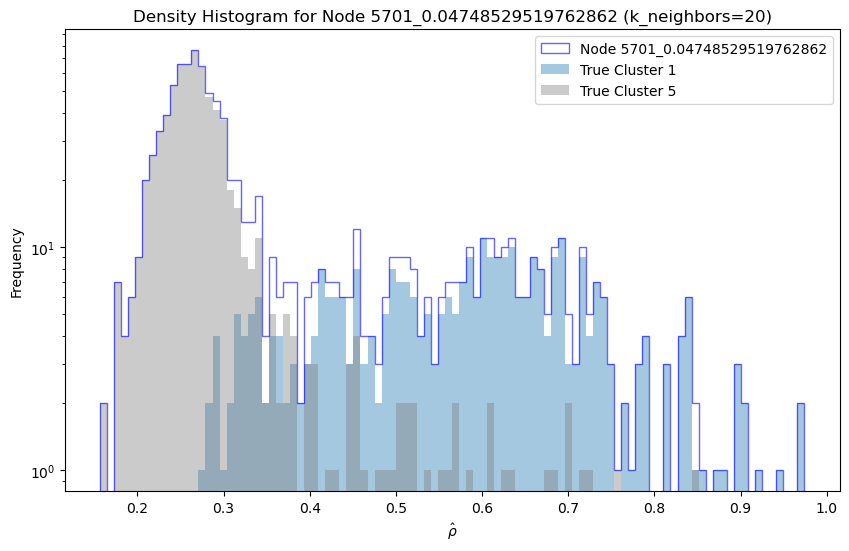

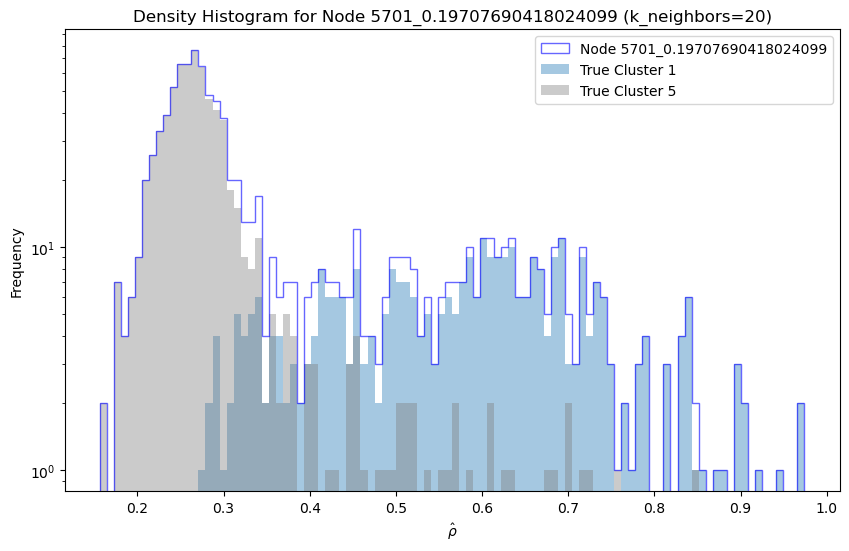

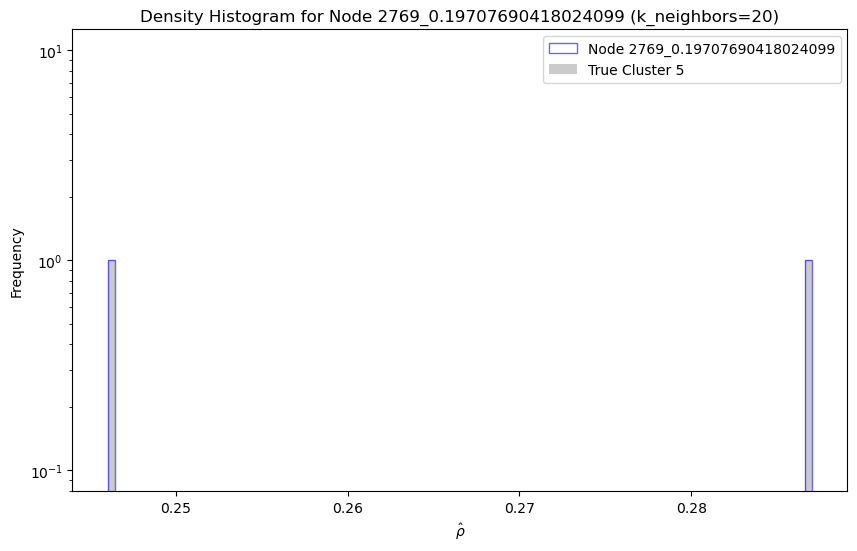

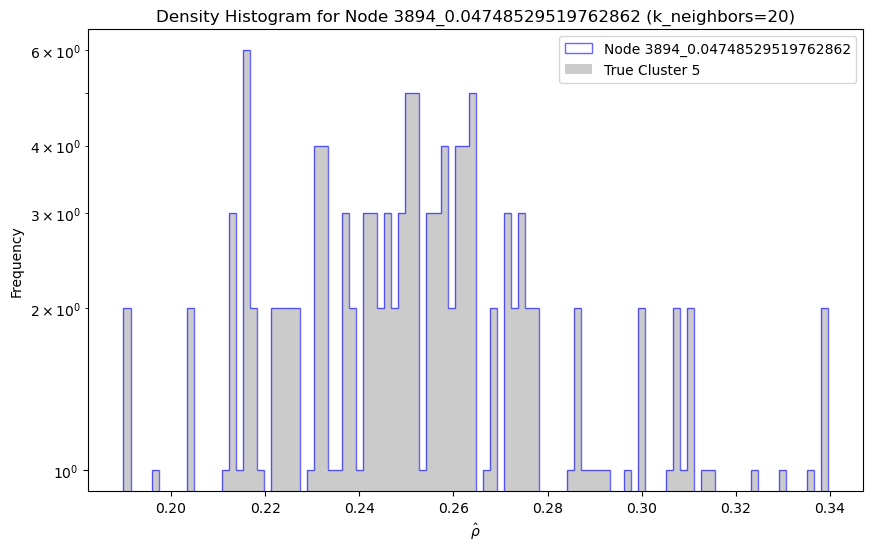

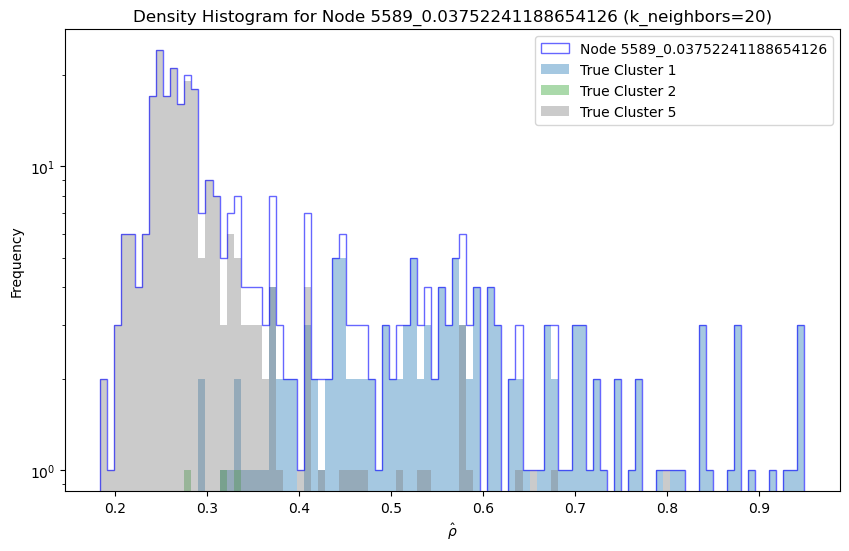

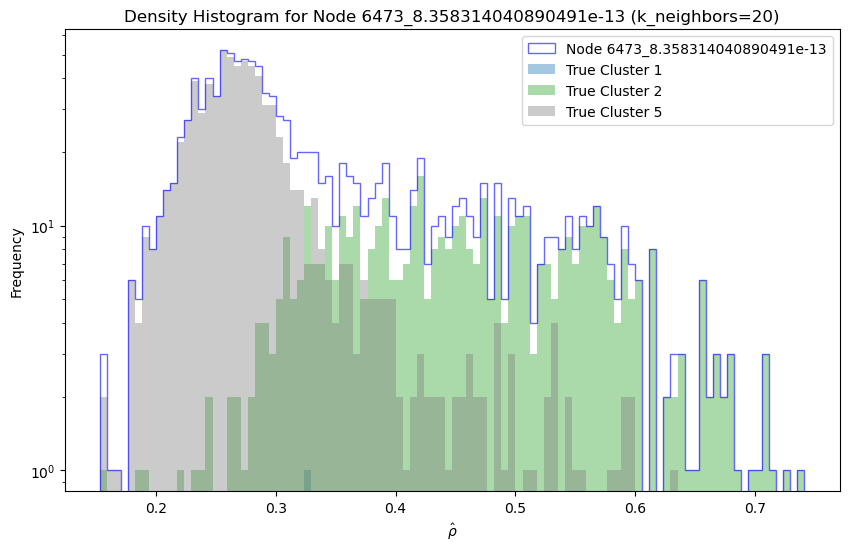

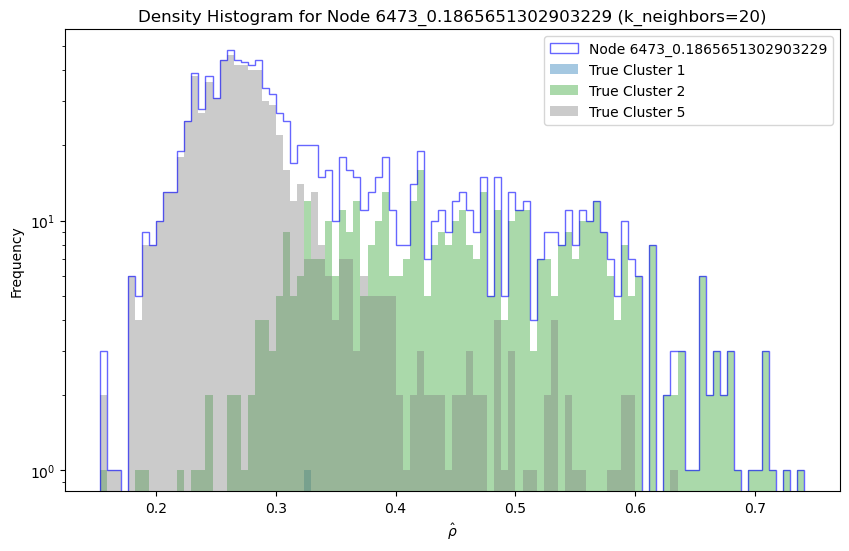

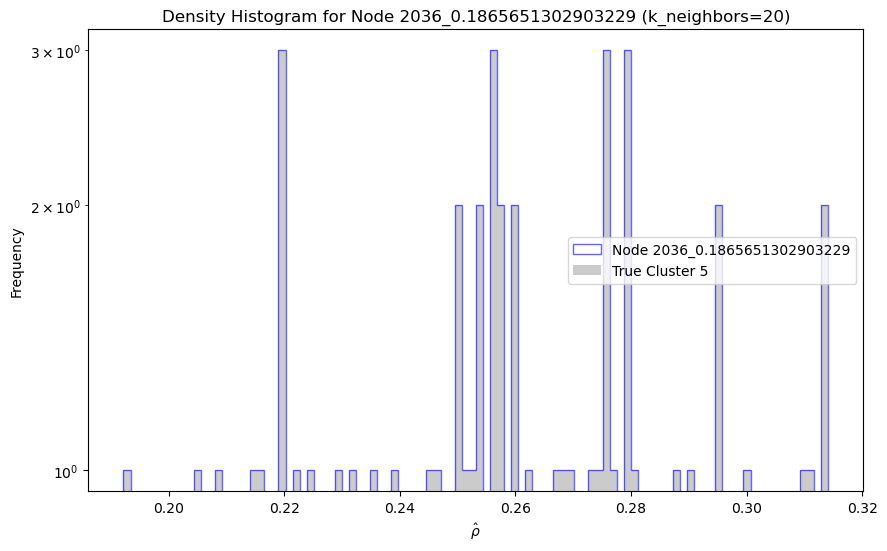

In [24]:
from scipy.spatial import KDTree

X = df[['x', 'y', 'z']].values  # Using XYZ for spatial positions

# Arrays with indices of the specific true clusters
clusters = [idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg]
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']

# Build a KDTree for distance queries
kd_tree = KDTree(X)

max_neighbors = max(knn_list)
k_neighbors = 20

# Dictionary to save kNN density for each node
knn_density_data = {}

# Iterate through each node in the hierarchy
for node in tree_sigma.hierarchy.traverse_top_down():
    if node.parent is None:  # Skip the root node
        continue
    # Retrieve data indices for the current node
    data_indices = node.data_indices

    # Query distances for points in the node's cluster
    k_dists, _ = kd_tree.query(X[data_indices], k=max_neighbors + 1, workers=-1)
    k_dists = np.sort(k_dists[:, 1:], axis=1)  # Exclude self-distance (0) and sort

    # Calculate KNN density
    knn_density = 1 / np.sqrt(np.mean(np.square(k_dists[:, :k_neighbors - 1]), axis=1))

    # Save the kNN density data for the node
    knn_density_data[node.node_id] = knn_density

    # Create a histogram plot for the current node
    plt.figure(figsize=(10, 6))
    _, bins, _ = plt.hist(knn_density, bins=100, alpha=0.6, color='blue', histtype='step', label=f"Node {node.node_id}", log=True)

    # Overlay histograms for the densities of the true ground truth clusters
    for i, true_cluster in enumerate(clusters):  # true_clusters = list(idx of real cluster 0,1,2,3,4 + bg)
        true_cluster_indices = np.intersect1d(data_indices, true_cluster)  # Indices in both the current node and true cluster
        if len(true_cluster_indices) > 0:  # Avoid empty histograms
            # Plot histogram for this true cluster
            knn_density_true = knn_density[np.isin(data_indices, true_cluster_indices)]
            plt.hist(knn_density_true, bins=bins, alpha=0.4, color=colors[i], histtype='stepfilled', label=f"True Cluster {i}")
    
    plt.xlabel(r'$\hat{\rho}$')
    plt.ylabel("Frequency")
    plt.title(f"Density Histogram for Node {node.node_id} (k_neighbors={k_neighbors})")
    plt.legend()
    plt.show()


## Signal Background contingency table

Threshold: 0.4820314700009045


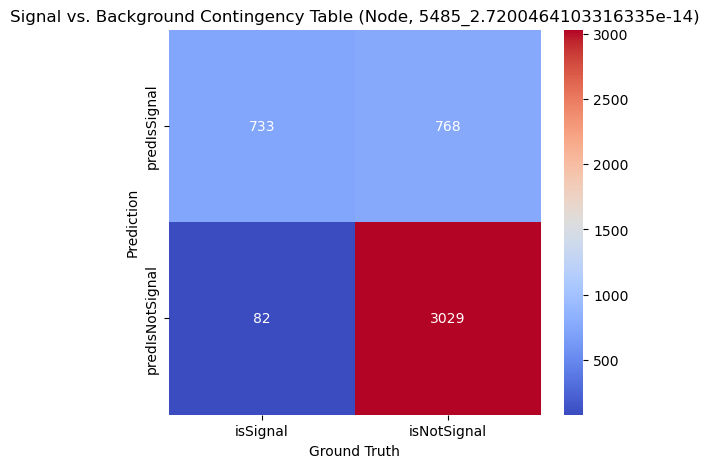

Ground Truth Labels for Node=5485_2.7200464103316335e-14: (array([0]), array([4612]))
Threshold: 0.5023318616431101


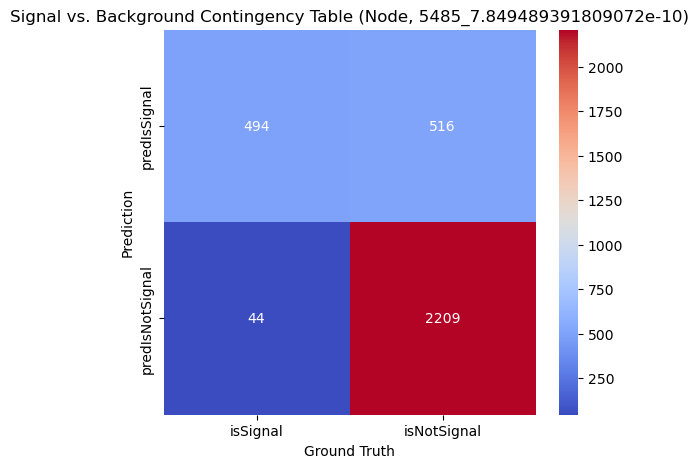

Ground Truth Labels for Node=5485_7.849489391809072e-10: (array([0]), array([3263]))
Threshold: 0.583562843787876


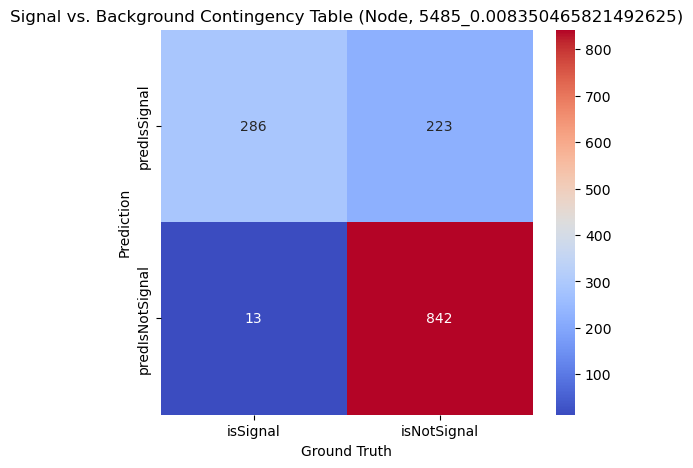

Ground Truth Labels for Node=5485_0.008350465821492625: (array([0]), array([1364]))
Threshold: 0.5060297239228521


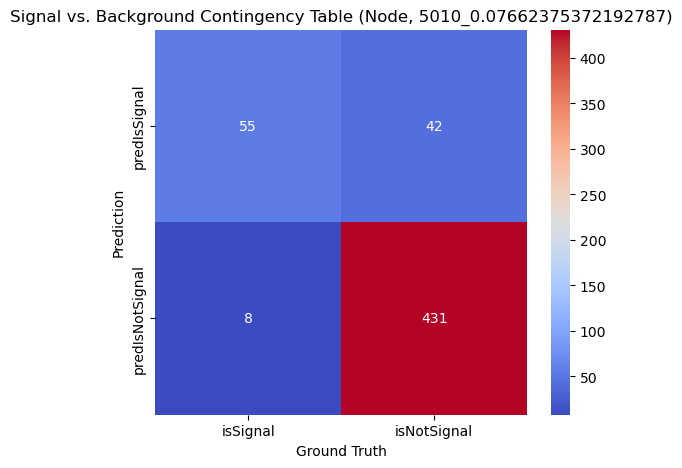

Ground Truth Labels for Node=5010_0.07662375372192787: (array([0]), array([536]))
Threshold: 0.6142474717107174


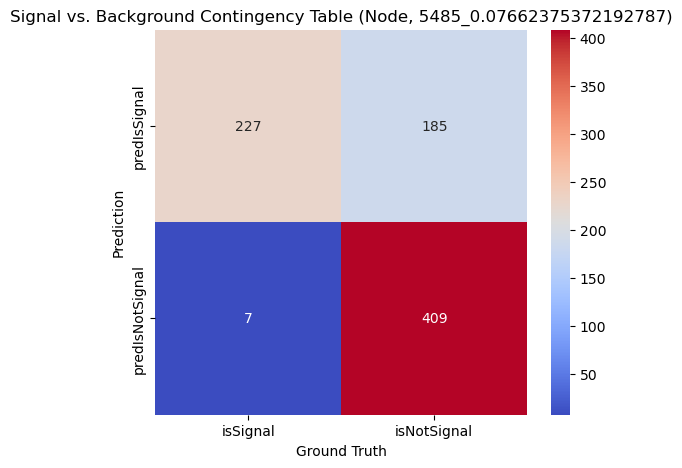

Ground Truth Labels for Node=5485_0.07662375372192787: (array([0]), array([828]))
Threshold: 0.6278906499961746


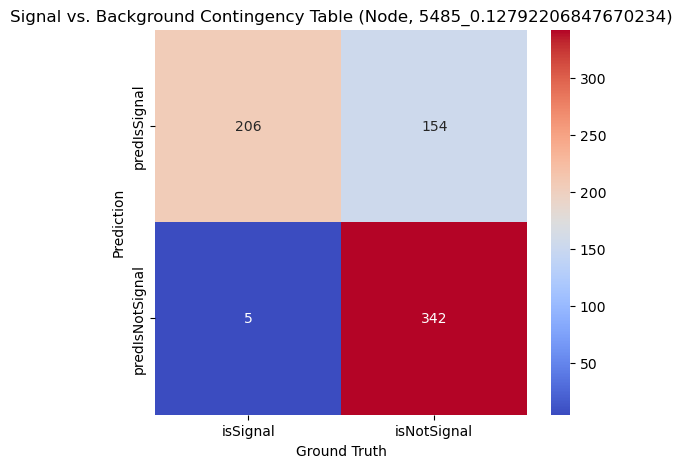

Ground Truth Labels for Node=5485_0.12792206847670234: (array([0]), array([707]))
Threshold: 0.6249584040448973


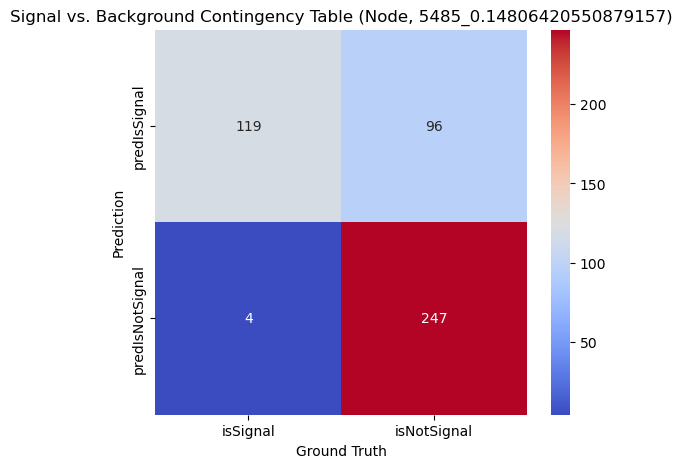

Ground Truth Labels for Node=5485_0.14806420550879157: (array([0]), array([466]))
Threshold: 0.6309444867045375


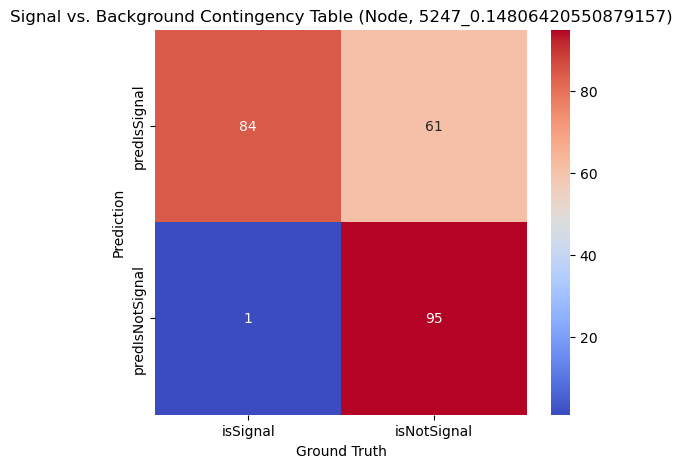

Ground Truth Labels for Node=5247_0.14806420550879157: (array([0]), array([241]))
Threshold: 0.5105568999450022


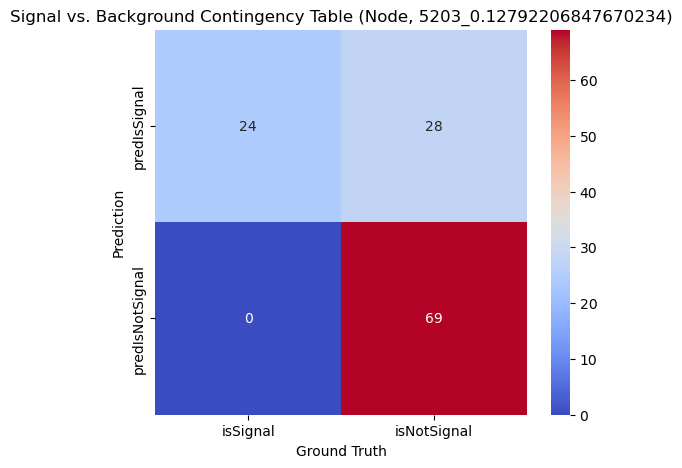

Ground Truth Labels for Node=5203_0.12792206847670234: (array([0]), array([121]))
Threshold: 0.452561032150127


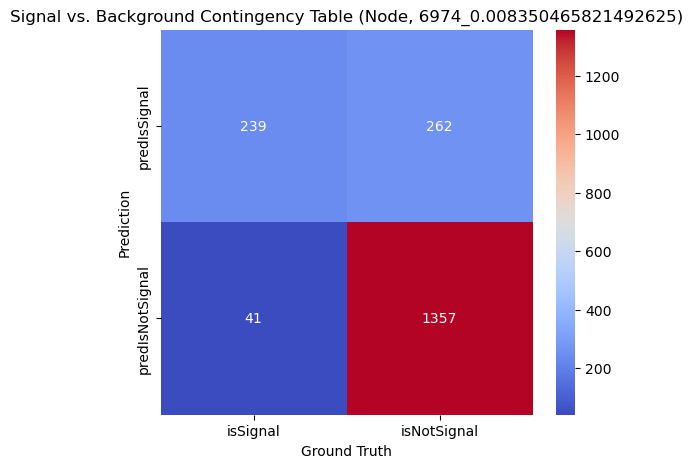

Ground Truth Labels for Node=6974_0.008350465821492625: (array([0]), array([1899]))
Threshold: 0.45281412580276875


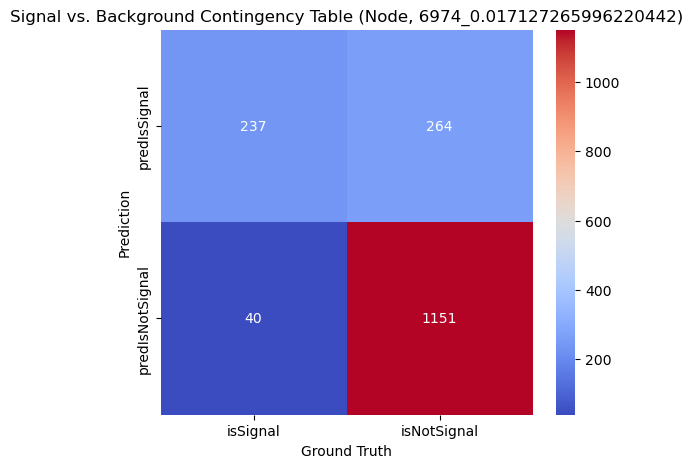

Ground Truth Labels for Node=6974_0.017127265996220442: (array([0]), array([1692]))
Threshold: 0.43024662213288195


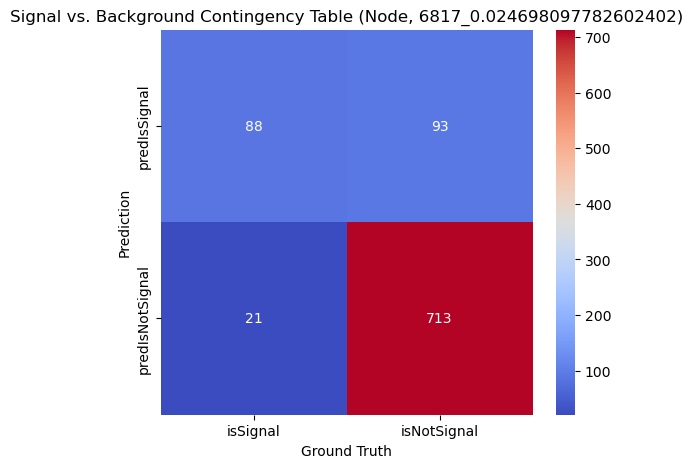

Ground Truth Labels for Node=6817_0.024698097782602402: (array([0]), array([915]))
Threshold: 0.4313385769451986


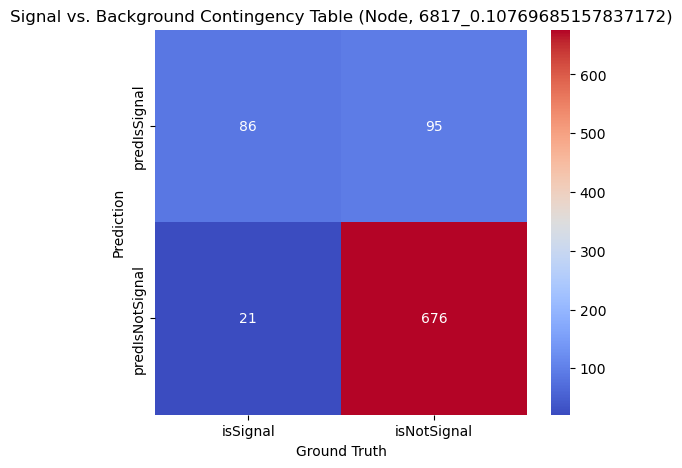

Ground Truth Labels for Node=6817_0.10769685157837172: (array([0]), array([878]))
Threshold: 0.4323782029451154


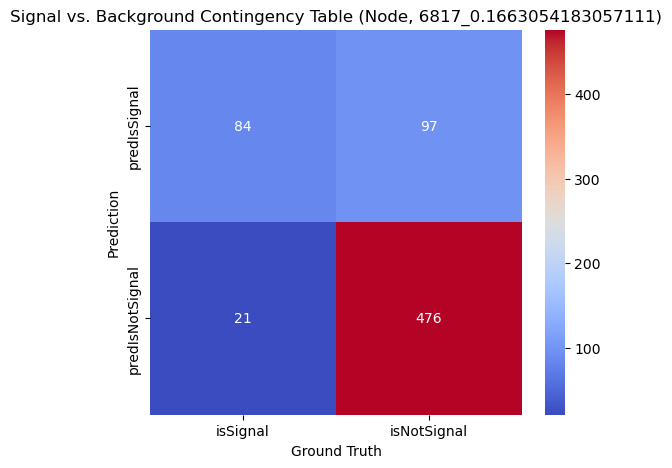

Ground Truth Labels for Node=6817_0.1663054183057111: (array([0]), array([678]))
Threshold: 0.2889217253702953


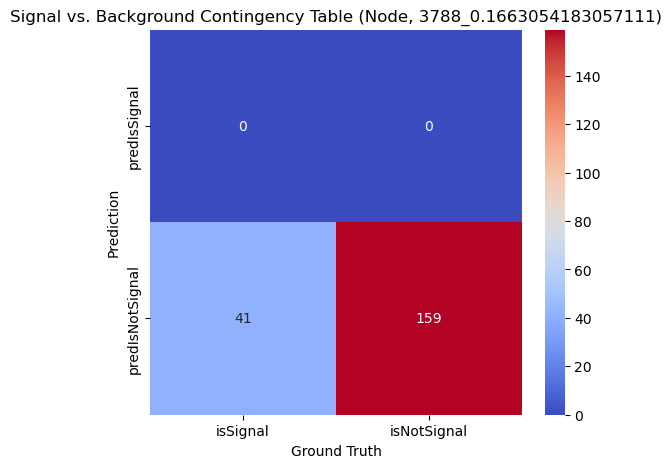

Ground Truth Labels for Node=3788_0.1663054183057111: (array([0]), array([200]))
Threshold: 0.25269279972341585


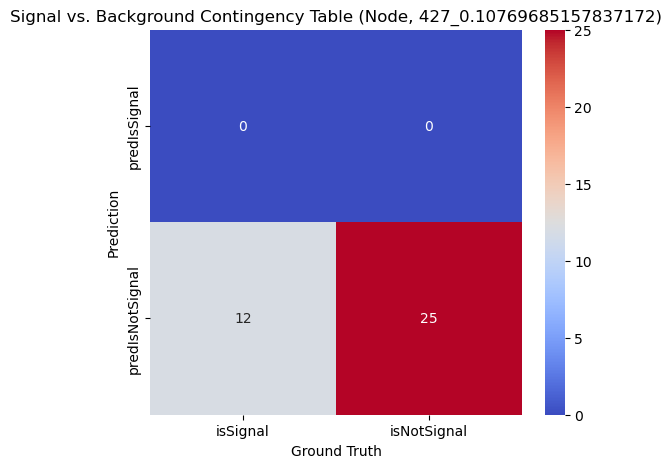

Ground Truth Labels for Node=427_0.10769685157837172: (array([0]), array([37]))
Threshold: 0.483058301977727


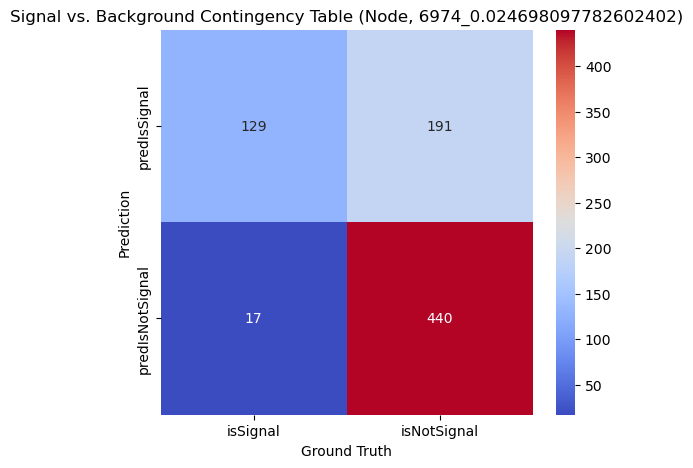

Ground Truth Labels for Node=6974_0.024698097782602402: (array([0]), array([777]))
Threshold: 0.27110679233717405


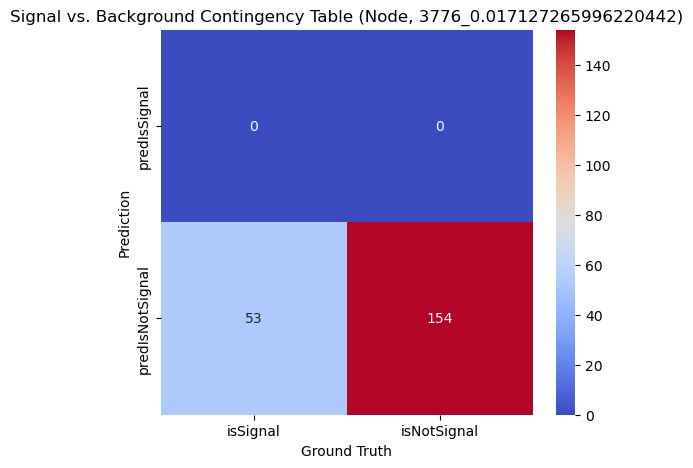

Ground Truth Labels for Node=3776_0.017127265996220442: (array([0]), array([207]))
Threshold: 0.4563399914281969


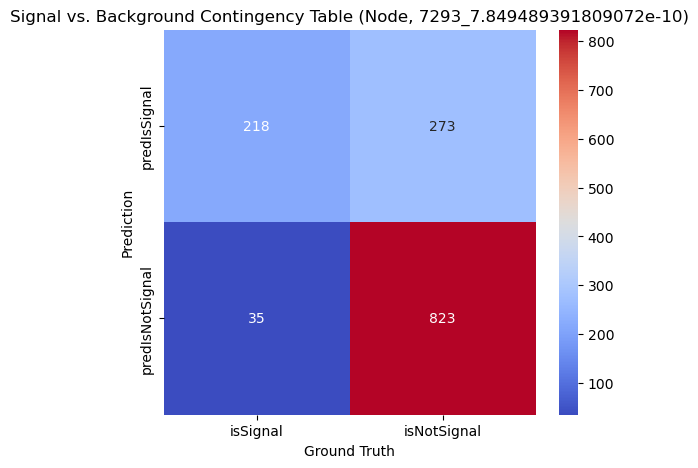

Ground Truth Labels for Node=7293_7.849489391809072e-10: (array([0]), array([1349]))
Threshold: 0.5045268541339545


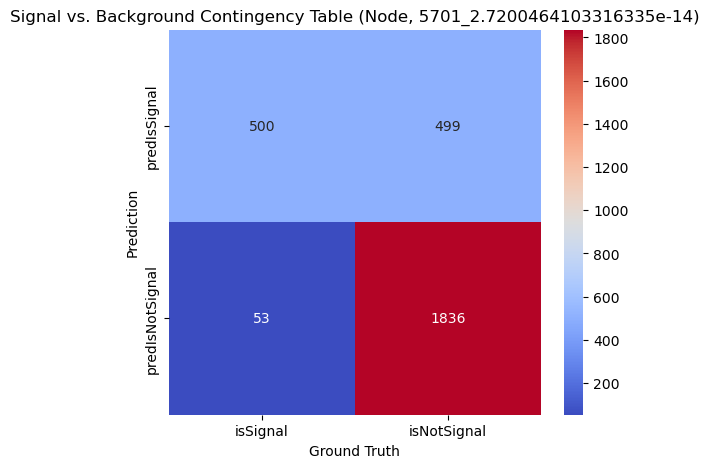

Ground Truth Labels for Node=5701_2.7200464103316335e-14: (array([0]), array([2888]))
Threshold: 0.5590040856324905


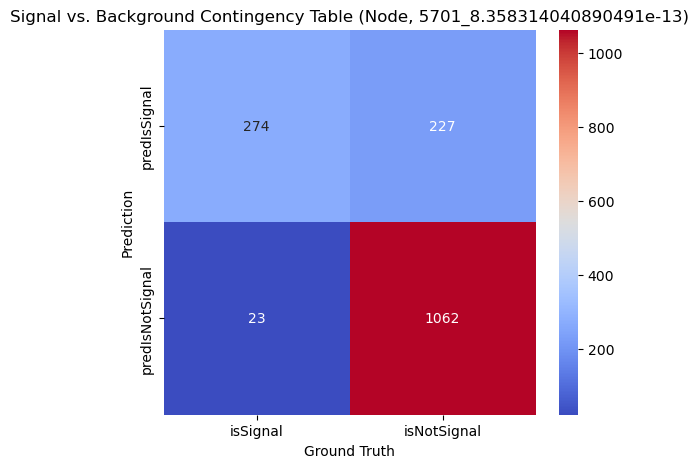

Ground Truth Labels for Node=5701_8.358314040890491e-13: (array([0]), array([1586]))
Threshold: 0.5669008228177155


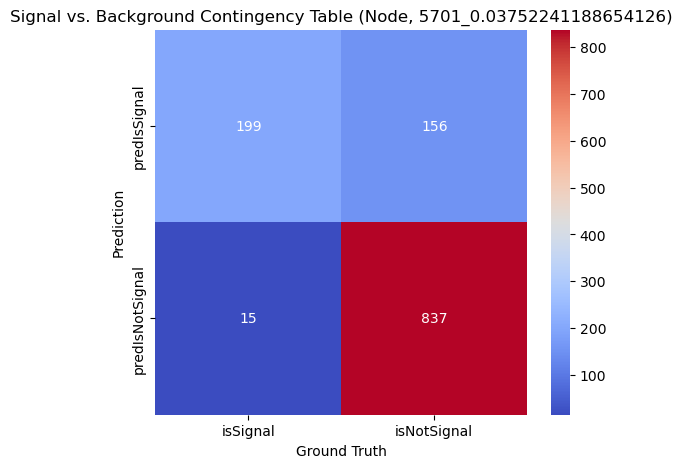

Ground Truth Labels for Node=5701_0.03752241188654126: (array([0]), array([1207]))
Threshold: 0.5691068881511551


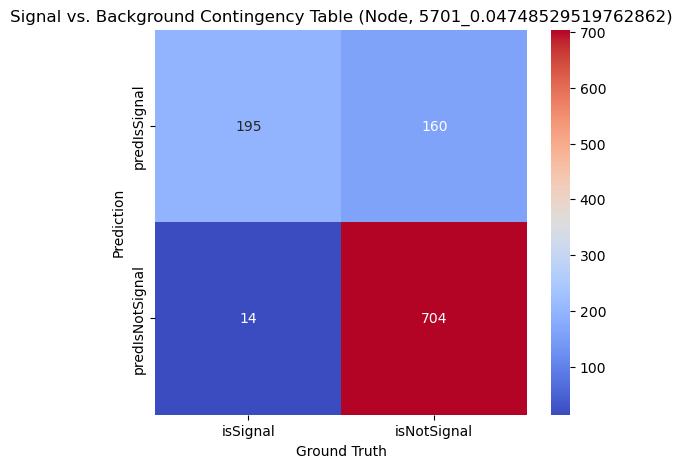

Ground Truth Labels for Node=5701_0.04748529519762862: (array([0]), array([1073]))
Threshold: 0.5691681735758914


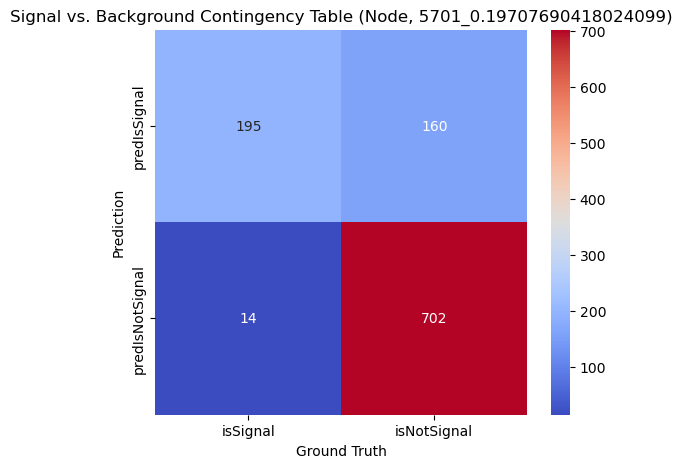

Ground Truth Labels for Node=5701_0.19707690418024099: (array([0]), array([1071]))
Threshold: 0.287044074873086


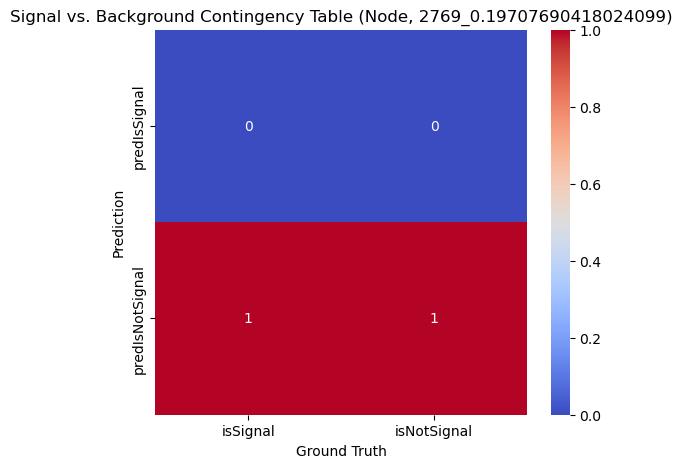

Ground Truth Labels for Node=2769_0.19707690418024099: (array([0]), array([2]))
Threshold: 0.2822927620143341


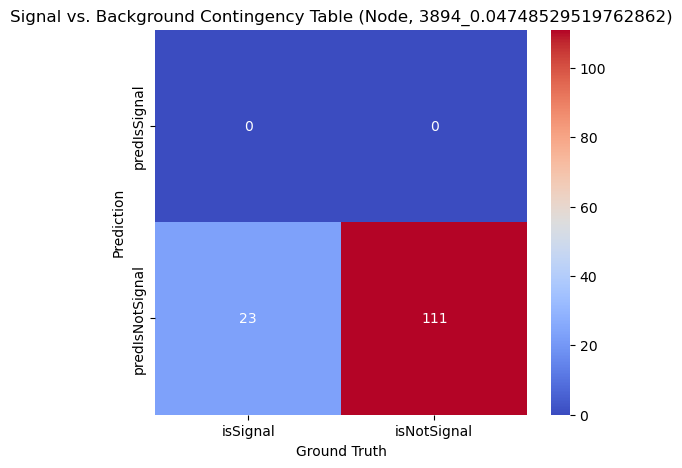

Ground Truth Labels for Node=3894_0.04748529519762862: (array([0]), array([134]))
Threshold: 0.5434050132765765


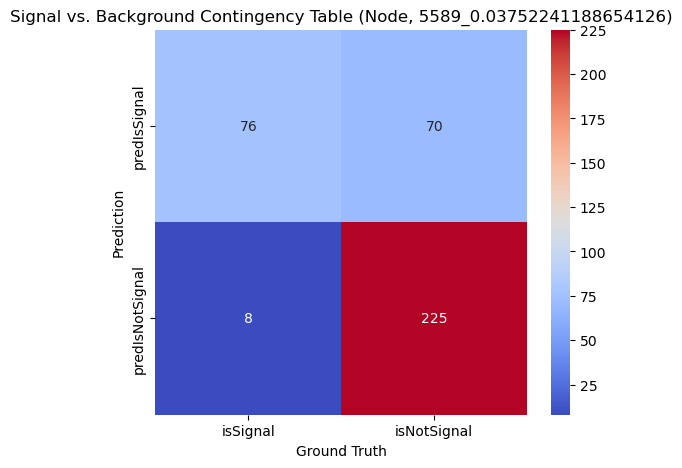

Ground Truth Labels for Node=5589_0.03752241188654126: (array([0]), array([379]))
Threshold: 0.4701036058702657


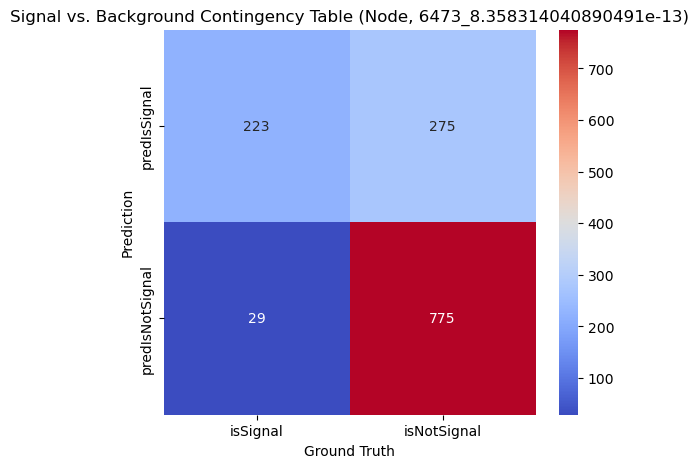

Ground Truth Labels for Node=6473_8.358314040890491e-13: (array([0]), array([1302]))
Threshold: 0.47329986976563204


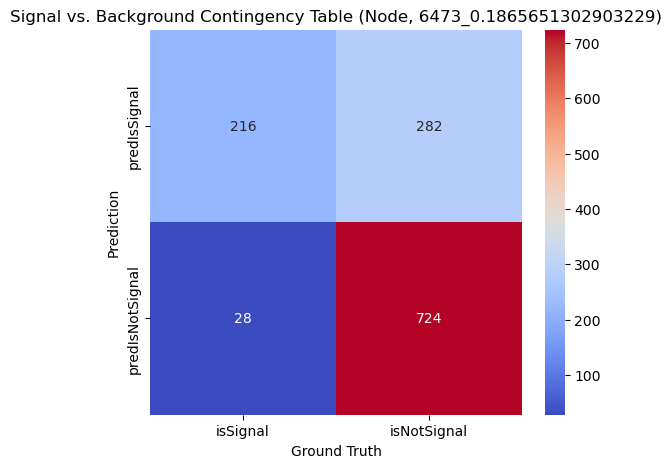

Ground Truth Labels for Node=6473_0.1865651302903229: (array([0]), array([1250]))
Threshold: 0.27971948681289166


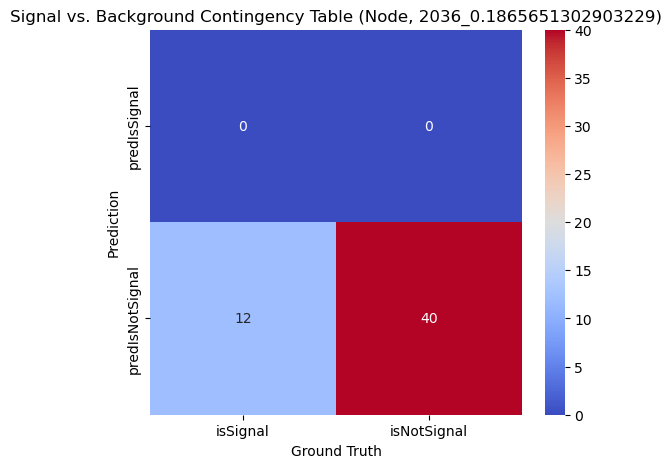

Ground Truth Labels for Node=2036_0.1865651302903229: (array([0]), array([52]))


In [26]:
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from collections import defaultdict

# Store the thresholds for each alpha level and cluster
thresholds = {}

# Iterate through each node in the hierarchy
for node in tree_sigma.hierarchy.traverse_top_down():
    if node.parent is None:  # Skip the root node
        continue
    
    # Fit GMM on kNN density
    knn_density = knn_density_data[node.node_id]
    gm = GaussianMixture(n_components=2, random_state=42)
    gm.fit(knn_density_data[node.node_id].reshape(-1, 1))
    
    # Extract means and define signal threshold
    means = gm.means_.flatten()
    threshold = np.sort(means)[1]  # Signal threshold
    
    # Save the threshold for this cluster
  #  threshold[node.node_id] = threshold
    
    signal_bg_labels = (knn_density > threshold).astype(int) #0 - pred bg, 1 - pred signal, len = len of stars in specific node
    
    print('Threshold:', threshold)
    
    # Retrieve data indices for the current node
    cluster_indices = node.data_indices  #len(signal_bg_labels= len(cluster_indices) 
    
    # Calculate statistics for true signal/background
    cluster_stats = defaultdict(lambda: {"signal_pred": 0, "bg_pred": 0, "true_signal": 0, "true_bg": 0})
    for true_cluster_id, true_cluster in enumerate(clusters): # true_clusters = list(idx of real cluster 0,1,2,3,4 + bg)
        # Get global indices of the current cluster
        cluster_global_indices = np.array(cluster_indices) 
    
        for global_idx in true_cluster:
            if global_idx not in cluster_global_indices:
                continue  # Skip points that are not in the current cluster
    
            local_idx = np.where(cluster_indices == global_idx)[0][0]
    
            # Check signal/background status
            is_signal = np.isin(global_idx, np.hstack([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5]))
    
            pred_signal = signal_bg_labels[local_idx] == 1  # Use local index for `signal_bg_labels`
    
            # Update statistics
            if is_signal:
                cluster_stats[true_cluster_id]["true_signal"] += 1
            else:
                cluster_stats[true_cluster_id]["true_bg"] += 1
    
            if pred_signal:
                cluster_stats[true_cluster_id]["signal_pred"] += 1
            else:
                cluster_stats[true_cluster_id]["bg_pred"] += 1
    
    # Define contingency table for signal vs background predictions
    tp = 0  # True Positive
    fn = 0  # False Negative
    fp = 0  # False Positive
    tn = 0  # True Negative
    
    for local_idx, pred_signal in enumerate(signal_bg_labels):  # Use local index
        global_idx = cluster_indices[local_idx]  # Map local index to global
        is_signal = np.isin(global_idx, np.hstack([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5]))
    
        if is_signal and pred_signal == 1:
            tp += 1
        elif is_signal and pred_signal == 0:
            fn += 1
        elif not is_signal and pred_signal == 1:
            fp += 1
        elif not is_signal and pred_signal == 0:
            tn += 1
    
    
    # Create the 2x2 matrix
    contingency_matrix = np.array([
        [tp, fn],  # Row 1: True Positives and False Negatives
        [fp, tn]   # Row 2: False Positives and True Negatives
    ])
    
    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        contingency_matrix,
        annot=True,
        fmt="d",
        cmap="coolwarm",
        xticklabels=["isSignal", "isNotSignal"],
        yticklabels=["predIsSignal", "predIsNotSignal"]
    )
    plt.title(f"Signal vs. Background Contingency Table (Node, {node.node_id})")
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.show()
    
    # Ensemble classifier
    features = np.column_stack([knn_density, signal_bg_labels]) 
    ground_truth_labels = np.array([
        1 if idx in np.hstack([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5]) else 0
        for idx in range(len(knn_density))
    ])
    print(f"Ground Truth Labels for Node={node.node_id}: {np.unique(ground_truth_labels, return_counts=True)}")
    
    
    ensemble_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    ensemble_classifier.fit(features, ground_truth_labels)
    
    # Make predictions
    if len(np.unique(ground_truth_labels)) > 1:  # Ensure at least two classes exist
        final_prediction = ensemble_classifier.predict(features)
        final_probability = ensemble_classifier.predict_proba(features)[:, 1]  # Probability of class 1
    else:
        final_prediction = np.zeros(len(features))  # Default to all zeros
        final_probability = np.zeros(len(features))  # Default probabilities to 0


## Average Signal Background ratio

In [51]:
knn_density_data, avg_signal_bg_ratio, sig_bg_mtx = tree_sigma.average_signal_bg_ratio(X, max_neighbors, k_neighbors)


In [53]:
np.unique(avg_signal_bg_ratio)

array([0.        , 0.14285714, 0.16666667, 0.2       , 0.25      ,
       0.28571429, 0.33333333, 0.4       , 0.42857143, 0.5       ,
       0.57142857, 0.6       , 0.66666667, 0.71428571, 0.75      ,
       0.8       , 0.83333333, 0.85714286, 1.        ])

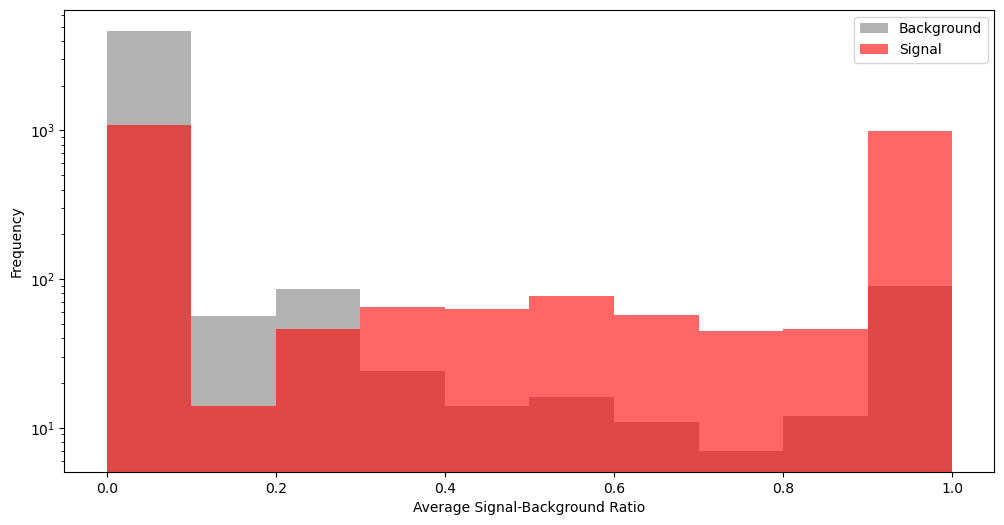

In [55]:
# Extract true signal and background indices from your setup
true_signal_indices = np.concatenate([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5])
true_background_indices = idx_bg

# Separate avg_signal_bg_ratio based on true signal and background indices
signal_ratios = avg_signal_bg_ratio[true_signal_indices]
background_ratios = avg_signal_bg_ratio[true_background_indices]

# Plot histograms
plt.figure(figsize=(12, 6))

# Background histogram in grey
plt.hist(background_ratios, bins=10, alpha=0.6, color='grey', label='Background', log=True)

# Signal histogram in red
plt.hist(signal_ratios, bins=10, alpha=0.6, color='red', label='Signal', log=True)

# Formatting the plot
plt.xlabel('Average Signal-Background Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Estimated vs True Plot

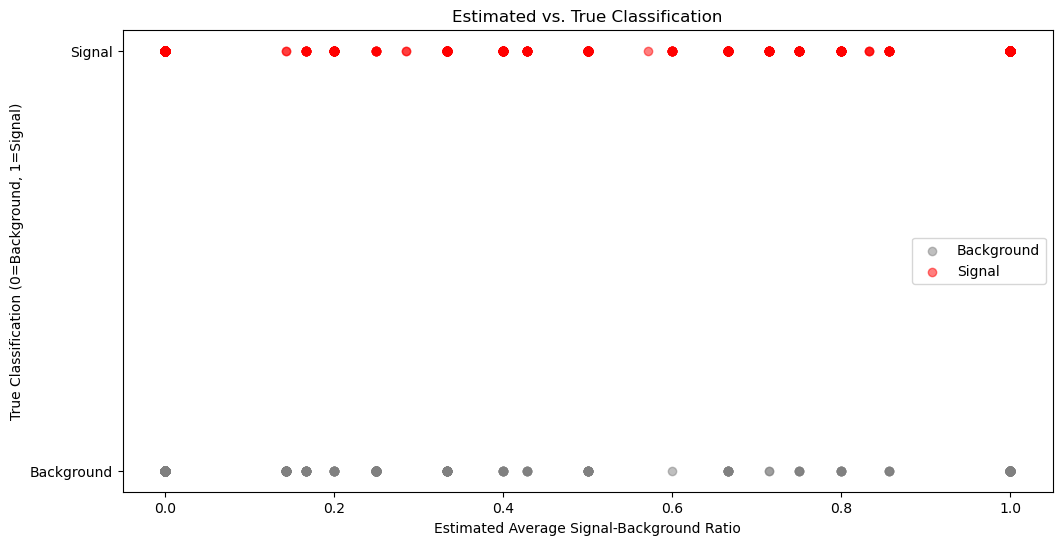

In [58]:
# Create labels for true background (0) and true signal (1)
true_labels = np.zeros(avg_signal_bg_ratio.shape)
true_labels[true_signal_indices] = 1

plt.figure(figsize=(12, 6))

plt.scatter(
    avg_signal_bg_ratio[true_background_indices],
    true_labels[true_background_indices],
    alpha=0.5,
    color='grey',
    label='Background'
)

plt.scatter(
    avg_signal_bg_ratio[true_signal_indices],
    true_labels[true_signal_indices],
    alpha=0.5,
    color='red',
    label='Signal'
)

plt.xlabel('Estimated Average Signal-Background Ratio')
plt.ylabel('True Classification (0=Background, 1=Signal)')
plt.yticks([0, 1], labels=['Background', 'Signal'])
plt.legend()
plt.title('Estimated vs. True Classification')
plt.show()


In [61]:
#Get for every node the sig_bg_array 
for node in tree_sigma.hierarchy.traverse_top_down():
    print(node.sig_bg_array)

None
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1
 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 